<a href="https://colab.research.google.com/github/imn22/Audio_denoising/blob/main/DLTS_Project_Presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Audio Denoising </h1>
-- Deep Learning for Signal Processing --


<h2> Introduction</h2>

Audio signals can be distorted due to various sources, from background noises to reverberations or multiple speakers, all leading to degraded speech intelligibility. This makes audio denoising a major problem in the field.

In this project, we address this issue by implementing and testing some of the algorithms used nowadays and discussing their efficiency and performance. We mainly focus on two approaches: the first one involves working on the spectrograms of the signals by implementing a denoising Unet, and the second approach involves working with the time-domain signal by performing some preprocessing and implementing a Wave Unet designed for this purpose. In the end, we compare the results obtained from our different training methods and discuss the effectiveness or lack thereof of some methods.

Additionnally, we will present some classical algorithms, as alternatives to the deep learning approaches.


<center><img src="https://drive.google.com/uc?export=view&id=1s9EeIm7VVrZmoZNRojkW3uAgV9B_oysr" alt="Approaches">
</center>

⚠ To make this notebook more concise, we've included only code snippets relevant to the presentation. For the complete code, please refer to the following github repository : https://github.com/imn22/Audio_denoising/tree/main  ⚠

In [ ]:
## Installs
!pip install torchmetrics
!pip install pesq
!pip install pystoi

In [ ]:
# Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import scipy
from IPython.core.display import display
import IPython.display as ipd
from tqdm import tqdm
from scipy.io import wavfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import zipfile
import time
import librosa
import matplotlib.pyplot as plt
import shutil
import psutil
from pesq import pesq
from pystoi.stoi import stoi

<h2> Data analysis and visualization</h2>

Our dataset is composed of a training and test set. The train set contains 2118 clean and noisy signals, and the test set 782 clean and noisy signals.
The signals themselves are all of legnth $N= 80000$ samples with a sampling frequency of $f_s= 8000$.


In [ ]:
root_path = '/content/data/data/'
train_small_path = '/content/data/data/train_small/'
train_path = '/content/data/data/train/'
test_path = '/content/data/data/test/'

In [ ]:
sig_noisy_path= "/content/data/data/train/noisy/signal/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_0_.wav"
sig_path= "/content/data/data/train/original/signal/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_0_.wav"

fs_noisy, sig_noisy = scipy.io.wavfile.read(sig_noisy_path)
fs, sig = scipy.io.wavfile.read(sig_path)

print("noisy singnal:")
display(ipd.Audio(data= sig_noisy, rate= fs))
print("original signal:")
display(ipd.Audio(data= sig, rate=fs))

noisy singnal:


original signal:


In [ ]:
#Sanity checks
from pathlib import Path

pathlist = Path(root_path).glob('**/*.wav')
for signal_path in pathlist:
    fs, sig = scipy.io.wavfile.read(signal_path)
    assert len(sig) == 80000
    assert fs == 8000

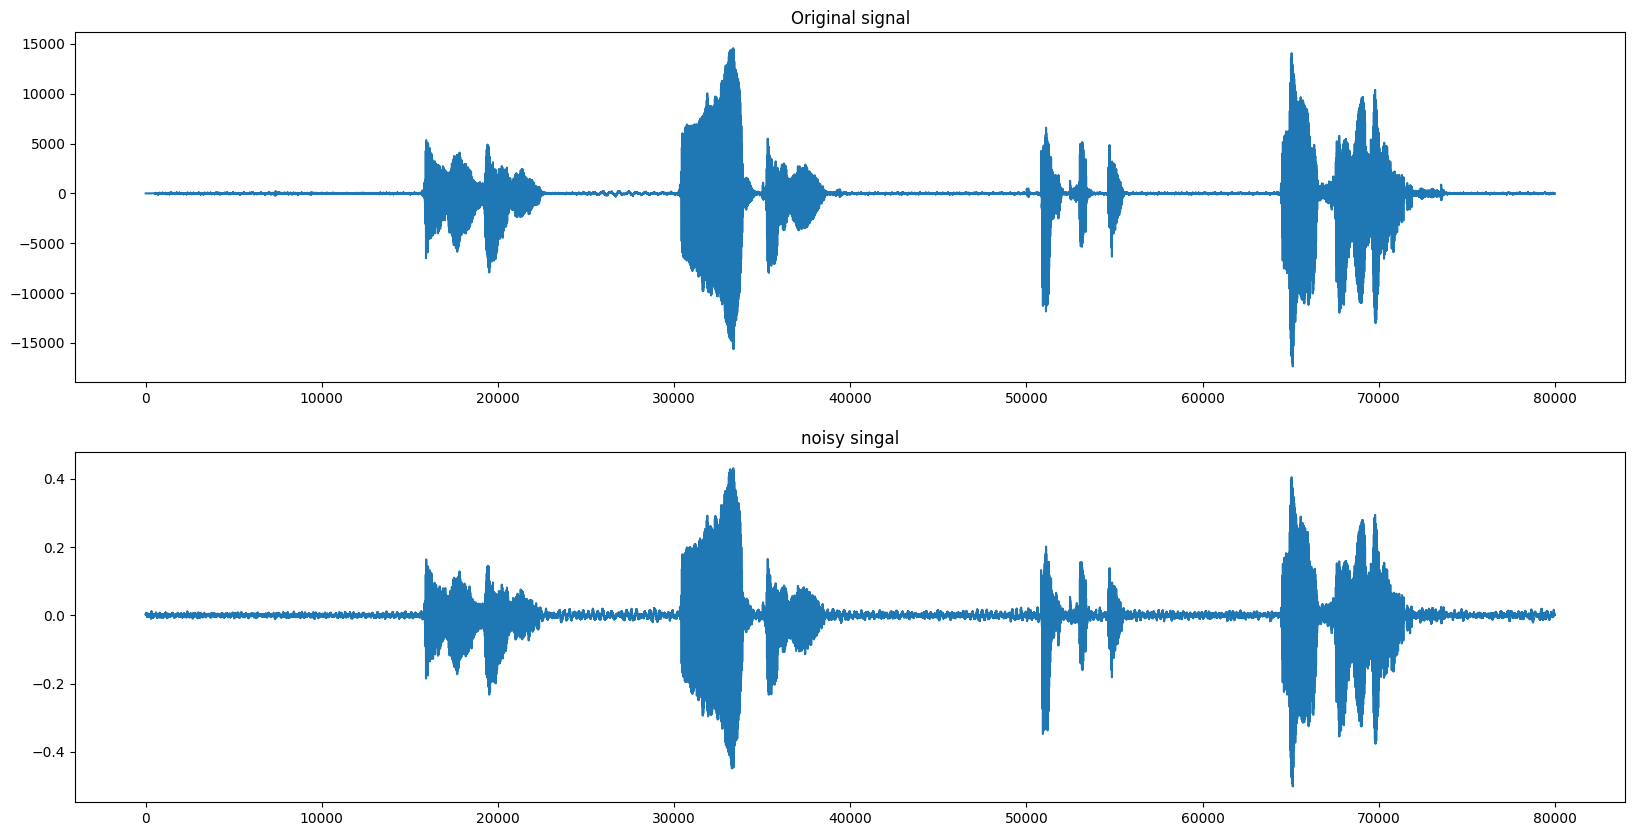

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(sig, label='orginal signal')
plt.title('Original signal')

plt.subplot(2,1,2)
plt.plot(sig_noisy)
plt.title("noisy singal")
plt.show()

We see that the given signals are not represented on the same scale, to compare both we normalize and plot the clean versus the noisy signal.

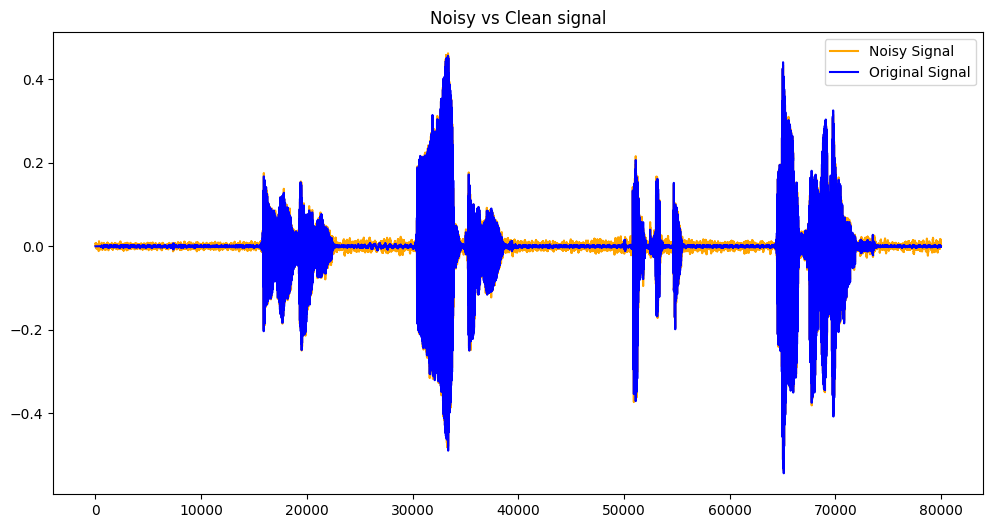

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot((sig_noisy - np.mean(sig_noisy)) / (np.max(sig_noisy) - np.min(sig_noisy)), label='Noisy Signal', color='orange')
plt.plot((sig - np.mean(sig)) / (np.max(sig) - np.min(sig)), label='Original Signal', color='blue')
plt.legend()
plt.title('Noisy vs Clean signal')
plt.show()

<h2>METHOD 1: Perform denoising on the Spectrograms</h2>

<h3>Visual representation of the time domain signals: </h3>

We begin by exploring the first approach, which involves obtaining visual representations of the signals for denoising. These representations are derived using the Short-Time Fourier Transform (STFT) algorithm, implemented in the librosa library, to convert signals from the time domain to the time-frequency domain. For each spectrogram, we apply a sliding window of size 512 and a step size of 256, resulting in spectrograms of dimensions (313, 257).

In this work, we make the assumption that the noise is additive. Consequently, it affects only the amplitude of the signal and therefeore the amplitude spectrogram since Fourier transform is a linear operation.AS a result, this additive noise does not affect the phase of the signal. The phase resentation will be stored only to be used in the reconstruction step after denoising.

Finally, we have created a new dataset comprising amplitude spectrograms and their corresponding phase information, matching the number of signals we possess. The amplitude spectrograms serve as inputs to our denoising model.



Text(0, 0.5, 'Frequency')

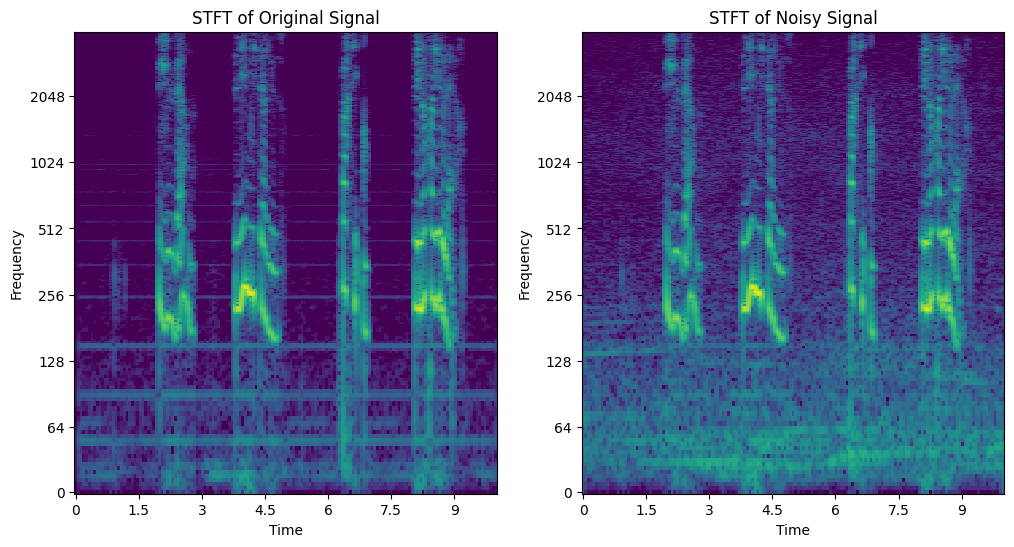

In [ ]:
#get stft
stft_noisy= librosa.stft(sig_noisy.astype(float))
stft_origin= librosa.stft(sig.astype(float))

# Displaying the results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

librosa.display.specshow(librosa.amplitude_to_db(abs(stft_origin)),
                         sr=fs_noisy, x_axis='time', y_axis='log', ax=ax[0], cmap='viridis')
ax[0].set_title('STFT of Original Signal')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Frequency')

librosa.display.specshow(librosa.amplitude_to_db(abs(stft_noisy)),
                         sr=fs, x_axis='time', y_axis='log', ax=ax[1], cmap='viridis')
ax[1].set_title('STFT of Noisy Signal')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Frequency')

<h3>The Unet architecture:</h3>

In this work, we used the Unet Model. It was initially introduced for medical image segmentation but was later adapted for denoising purposes.

The architecture resembles the letter 'U', which gives it its name. It consists of a contracting (downsampling) path and an expansive (upsampling) path, making it symmetrical.
The contracting path is a typical convolutional neural network. It consists of repeated application double convolutions with 3x3 kernels followed by (ReLU) activation layers and pooling layers, which reduce the spatial dimensions of the image (downsampling). on the other hand the number of channel is doubles at each layer. The expansive path, includes up-convolutional layers which increase the spatial dimensions of the image (upsampling) followed by convolutional layers to half the number of layers. In addititon there  are skip connections that connect layers of equal resolution in the contracting path to layers in the expansive path.

In our context, we start by spectrograms of resolution 256x256 then apply 4 downsampling layers that half the spacial resolution and double the feature channed at each step to result in feature of shape [512, 16,16] at the boltleneck for which we further apply a double convolution to result in a size of [1024,16,16] and finally we perform the symetric operations on the upsampling path, in addition to concatenating with the feature maps of the same resolution from the contracting path as mentionned.

A genral architecture of the Unet is displayed below:

![Unet Architecture](https://drive.google.com/uc?export=view&id=1I9NQL3nhM7J_9_uV70bxidshwb7fPKc9)




<h3>Train 1:</h3>

loss function= MSE Loss

learning rate= 0.1 with exponenetial scheduler

batch size=1

number of epochs=50


Loading the data...
Device: cuda

 start training


  0%|          | 0/50 [00:00<?, ?it/s]

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_0.pth


  2%|▏         | 1/50 [04:16<3:29:31, 256.57s/it]

Epoch 1, Train Loss: 4066.6253, Validation Loss: 3531.9172, Average PESQ: 1.2700, Average STOI: 0.4758


  4%|▍         | 2/50 [08:02<3:10:51, 238.57s/it]

Epoch 2, Train Loss: 6281.9951, Validation Loss: 224.6288, Average PESQ: 1.1893, Average STOI: 0.4611
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_2.pth


  6%|▌         | 3/50 [11:49<3:02:41, 233.22s/it]

Epoch 3, Train Loss: 183.9810, Validation Loss: 71.6804, Average PESQ: 2.0897, Average STOI: 0.7956
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_3.pth


  8%|▊         | 4/50 [15:37<2:57:17, 231.26s/it]

Epoch 4, Train Loss: 67.0537, Validation Loss: 54.4080, Average PESQ: 2.3265, Average STOI: 0.8497
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_4.pth


 10%|█         | 5/50 [19:26<2:52:39, 230.22s/it]

Epoch 5, Train Loss: 58.8942, Validation Loss: 50.2797, Average PESQ: 2.3919, Average STOI: 0.8510
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_5.pth


 12%|█▏        | 6/50 [23:15<2:48:31, 229.80s/it]

Epoch 6, Train Loss: 55.0445, Validation Loss: 58.6500, Average PESQ: 2.4988, Average STOI: 0.8537
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_6.pth


 14%|█▍        | 7/50 [27:03<2:44:29, 229.53s/it]

Epoch 7, Train Loss: 50.6150, Validation Loss: 42.7905, Average PESQ: 2.5769, Average STOI: 0.8740
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_7.pth


 16%|█▌        | 8/50 [30:52<2:40:21, 229.09s/it]

Epoch 8, Train Loss: 46.9878, Validation Loss: 42.5202, Average PESQ: 2.7292, Average STOI: 0.8733
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_8.pth


 18%|█▊        | 9/50 [34:40<2:36:27, 228.96s/it]

Epoch 9, Train Loss: 45.4075, Validation Loss: 51.4671, Average PESQ: 2.3265, Average STOI: 0.8790
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_9.pth


 20%|██        | 10/50 [38:28<2:32:17, 228.43s/it]

Epoch 10, Train Loss: 44.0559, Validation Loss: 39.9601, Average PESQ: 2.6960, Average STOI: 0.8742
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_10.pth


 22%|██▏       | 11/50 [42:15<2:28:22, 228.27s/it]

Epoch 11, Train Loss: 42.0239, Validation Loss: 37.8914, Average PESQ: 2.6830, Average STOI: 0.8833
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_11.pth


 24%|██▍       | 12/50 [46:03<2:24:23, 227.97s/it]

Epoch 12, Train Loss: 41.1661, Validation Loss: 37.3318, Average PESQ: 2.6516, Average STOI: 0.8892
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_12.pth


 26%|██▌       | 13/50 [49:51<2:20:36, 228.01s/it]

Epoch 13, Train Loss: 40.2147, Validation Loss: 36.3486, Average PESQ: 2.6849, Average STOI: 0.8849
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_13.pth


 28%|██▊       | 14/50 [53:39<2:16:54, 228.18s/it]

Epoch 14, Train Loss: 39.1446, Validation Loss: 36.4040, Average PESQ: 2.6557, Average STOI: 0.8811
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_14.pth


 30%|███       | 15/50 [57:30<2:13:29, 228.83s/it]

Epoch 15, Train Loss: 38.2585, Validation Loss: 46.3743, Average PESQ: 2.6241, Average STOI: 0.8846
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_15.pth


 32%|███▏      | 16/50 [1:01:21<2:10:05, 229.56s/it]

Epoch 16, Train Loss: 37.5200, Validation Loss: 35.2926, Average PESQ: 2.6804, Average STOI: 0.8850
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_16.pth


 34%|███▍      | 17/50 [1:05:11<2:06:23, 229.80s/it]

Epoch 17, Train Loss: 37.0378, Validation Loss: 34.6846, Average PESQ: 2.6724, Average STOI: 0.8893
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_17.pth


 36%|███▌      | 18/50 [1:09:01<2:02:30, 229.70s/it]

Epoch 18, Train Loss: 36.4863, Validation Loss: 34.0332, Average PESQ: 2.7105, Average STOI: 0.8879
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_18.pth


 38%|███▊      | 19/50 [1:12:50<1:58:35, 229.54s/it]

Epoch 19, Train Loss: 35.6607, Validation Loss: 35.9176, Average PESQ: 2.7232, Average STOI: 0.8834
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_19.pth


 40%|████      | 20/50 [1:16:39<1:54:38, 229.28s/it]

Epoch 20, Train Loss: 35.4891, Validation Loss: 36.4804, Average PESQ: 2.6306, Average STOI: 0.8829
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_20.pth


 42%|████▏     | 21/50 [1:20:28<1:50:45, 229.14s/it]

Epoch 21, Train Loss: 34.9879, Validation Loss: 33.9854, Average PESQ: 2.6493, Average STOI: 0.8879
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_21.pth


 44%|████▍     | 22/50 [1:24:16<1:46:50, 228.96s/it]

Epoch 22, Train Loss: 34.5544, Validation Loss: 33.6292, Average PESQ: 2.7312, Average STOI: 0.8869
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_22.pth


 46%|████▌     | 23/50 [1:28:04<1:42:50, 228.54s/it]

Epoch 23, Train Loss: 34.2627, Validation Loss: 33.2366, Average PESQ: 2.7159, Average STOI: 0.8906
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_23.pth


 48%|████▊     | 24/50 [1:31:50<1:38:45, 227.89s/it]

Epoch 24, Train Loss: 34.0549, Validation Loss: 33.3135, Average PESQ: 2.7228, Average STOI: 0.8926
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_24.pth


 50%|█████     | 25/50 [1:35:39<1:35:08, 228.33s/it]

Epoch 25, Train Loss: 33.5734, Validation Loss: 33.1719, Average PESQ: 2.7322, Average STOI: 0.8904
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_25.pth


 52%|█████▏    | 26/50 [1:39:30<1:31:34, 228.95s/it]

Epoch 26, Train Loss: 33.4476, Validation Loss: 32.9106, Average PESQ: 2.6788, Average STOI: 0.8895
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_26.pth


 54%|█████▍    | 27/50 [1:43:22<1:28:08, 229.92s/it]

Epoch 27, Train Loss: 33.1359, Validation Loss: 33.3917, Average PESQ: 2.6978, Average STOI: 0.8865
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_27.pth


 56%|█████▌    | 28/50 [1:47:14<1:24:30, 230.50s/it]

Epoch 28, Train Loss: 33.0595, Validation Loss: 32.6164, Average PESQ: 2.7060, Average STOI: 0.8913
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_28.pth


 58%|█████▊    | 29/50 [1:51:04<1:20:41, 230.54s/it]

Epoch 29, Train Loss: 32.8293, Validation Loss: 32.9117, Average PESQ: 2.7207, Average STOI: 0.8889
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_29.pth


 60%|██████    | 30/50 [1:54:55<1:16:52, 230.64s/it]

Epoch 30, Train Loss: 32.6892, Validation Loss: 33.2748, Average PESQ: 2.7161, Average STOI: 0.8882
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_30.pth


 62%|██████▏   | 31/50 [1:58:45<1:12:54, 230.22s/it]

Epoch 31, Train Loss: 32.4730, Validation Loss: 32.6101, Average PESQ: 2.6924, Average STOI: 0.8891
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_31.pth


 64%|██████▍   | 32/50 [2:02:33<1:08:54, 229.70s/it]

Epoch 32, Train Loss: 32.3328, Validation Loss: 32.4992, Average PESQ: 2.7275, Average STOI: 0.8912
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_32.pth


 66%|██████▌   | 33/50 [2:06:21<1:04:57, 229.28s/it]

Epoch 33, Train Loss: 32.2750, Validation Loss: 33.0183, Average PESQ: 2.7322, Average STOI: 0.8900
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_33.pth


 68%|██████▊   | 34/50 [2:10:09<1:01:00, 228.79s/it]

Epoch 34, Train Loss: 32.0819, Validation Loss: 32.3095, Average PESQ: 2.7027, Average STOI: 0.8900
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_34.pth


 70%|███████   | 35/50 [2:13:56<57:02, 228.16s/it]  

Epoch 35, Train Loss: 32.0384, Validation Loss: 32.2171, Average PESQ: 2.7127, Average STOI: 0.8910
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_35.pth


 72%|███████▏  | 36/50 [2:17:43<53:10, 227.92s/it]

Epoch 36, Train Loss: 31.9818, Validation Loss: 32.3998, Average PESQ: 2.7060, Average STOI: 0.8888
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_36.pth


 74%|███████▍  | 37/50 [2:21:32<49:28, 228.34s/it]

Epoch 37, Train Loss: 31.7913, Validation Loss: 32.6927, Average PESQ: 2.6868, Average STOI: 0.8907
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_37.pth


 76%|███████▌  | 38/50 [2:25:22<45:44, 228.68s/it]

Epoch 38, Train Loss: 31.7413, Validation Loss: 32.2522, Average PESQ: 2.7188, Average STOI: 0.8896
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_38.pth


 78%|███████▊  | 39/50 [2:29:11<41:57, 228.86s/it]

Epoch 39, Train Loss: 31.6526, Validation Loss: 32.2501, Average PESQ: 2.7082, Average STOI: 0.8918
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_39.pth


 80%|████████  | 40/50 [2:33:00<38:07, 228.73s/it]

Epoch 40, Train Loss: 31.6173, Validation Loss: 32.3386, Average PESQ: 2.7128, Average STOI: 0.8915
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_40.pth


 82%|████████▏ | 41/50 [2:36:49<34:20, 228.90s/it]

Epoch 41, Train Loss: 31.5612, Validation Loss: 32.2227, Average PESQ: 2.6986, Average STOI: 0.8909
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_41.pth


 84%|████████▍ | 42/50 [2:40:37<30:30, 228.81s/it]

Epoch 42, Train Loss: 31.4684, Validation Loss: 32.3371, Average PESQ: 2.7052, Average STOI: 0.8911
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_42.pth


 86%|████████▌ | 43/50 [2:44:27<26:42, 228.95s/it]

Epoch 43, Train Loss: 31.4529, Validation Loss: 32.1293, Average PESQ: 2.7175, Average STOI: 0.8901
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_43.pth


 88%|████████▊ | 44/50 [2:48:16<22:53, 228.97s/it]

Epoch 44, Train Loss: 31.3845, Validation Loss: 32.1505, Average PESQ: 2.7078, Average STOI: 0.8912
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_44.pth


 90%|█████████ | 45/50 [2:52:05<19:05, 229.00s/it]

Epoch 45, Train Loss: 31.3666, Validation Loss: 32.0935, Average PESQ: 2.7133, Average STOI: 0.8917
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_45.pth


 92%|█████████▏| 46/50 [2:55:53<15:14, 228.74s/it]

Epoch 46, Train Loss: 31.3368, Validation Loss: 32.2384, Average PESQ: 2.7192, Average STOI: 0.8896
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_46.pth


 94%|█████████▍| 47/50 [2:59:42<11:26, 228.75s/it]

Epoch 47, Train Loss: 31.2843, Validation Loss: 32.0990, Average PESQ: 2.7059, Average STOI: 0.8912
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_47.pth


 96%|█████████▌| 48/50 [3:03:30<07:37, 228.64s/it]

Epoch 48, Train Loss: 31.2615, Validation Loss: 32.0728, Average PESQ: 2.7137, Average STOI: 0.8910
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_48.pth


 98%|█████████▊| 49/50 [3:07:18<03:48, 228.30s/it]

Epoch 49, Train Loss: 31.2259, Validation Loss: 32.1064, Average PESQ: 2.7136, Average STOI: 0.8905
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints/checkpoint_ep_49.pth


100%|██████████| 50/50 [3:11:04<00:00, 229.29s/it]

Epoch 50, Train Loss: 31.2019, Validation Loss: 32.0928, Average PESQ: 2.7074, Average STOI: 0.8904


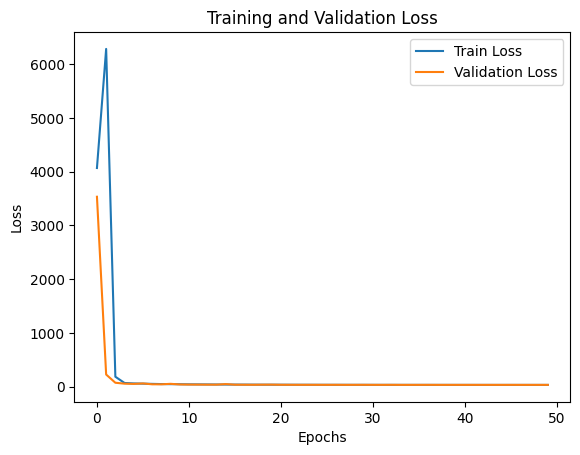

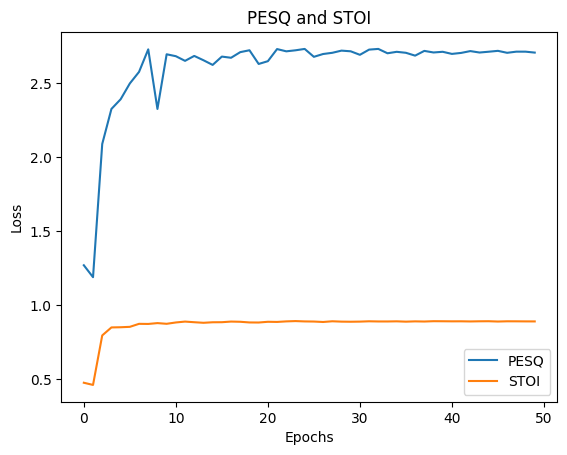

In [ ]:
#bluid train loop
from torch import nn
from train_unet import train
from model import My_unet
model= My_unet(in_channels=1, out_channels=1)
loss= nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1)
scheduler= torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
nepochs= 50
batch_size= 1
train_losses, val_losses, val_pesq_scores, val_stoi_scores= train(model, data_path='/content/data/data/train/', batch_size= batch_size, n_epochs= nepochs, transform=transform, save_dir='/content/drive/MyDrive/Dlts_project/checkpoints')
# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
plt.plot(val_pesq_scores, label='PESQ')
plt.plot(val_stoi_scores, label='STOI')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('PESQ and STOI')
plt.legend()
plt.show()



Then we perform testing

In [ ]:
# test the model:
from torch import nn
from test_unet import test
from model import My_unet

model= My_unet(in_channels=1, out_channels=1)

nepochs= 5
batch_size= 1
average_test_loss, average_snr_score,average_pesq_score, average_stoi_score= test(model, data_path='data/data/test/',checkpoint_path='/content/drive/MyDrive/Dlts_project/checkpoints_square/checkpoint_ep_49.pth', batch_size= batch_size, transform=transform, save_dir='/content/drive/MyDrive/Dlts_project/results_square')

Loading the data...
Device: cuda


  0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 1/782 [00:01<24:47,  1.90s/it]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCro

Test Loss: 32.3043, Average SNR: 3.8760, Average PESQ: 2.7119, Average STOI: 0.8890
saved result dict !


original signal


noisy signal


retreived signal


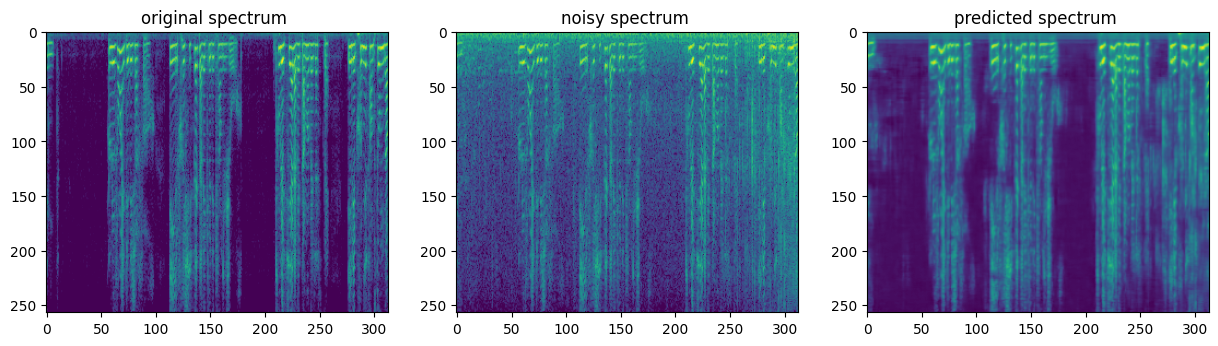

In [ ]:
#write a fucntion to retreive the results a compare the audios
import pickle
from data import retreive_sig
result_dict_path= '/content/drive/MyDrive/Dlts_project/results/result_dict.pickle'
data_path='/content/data/data/test/'

def read_results(result_dict_path, data_path):
  with open(result_dict_path, 'rb') as f:
    result_dict= pickle.load(f)
  file_names= result_dict['file_name']
  predicted_spec= result_dict['predicted_spec']
  noisy_phase= result_dict['noisy_phase']
  idx= np.random.randint(0, len(file_names))
  #dispaly specs
  original_spec= np.load(os.path.join(data_path, 'original', 'spec',file_names[idx][0]+'.npy'))
  noisy_spec= np.load(os.path.join(data_path, 'noisy', 'spec', file_names[idx][0]+'.npy'))
  predicted_spec= predicted_spec[idx].squeeze(axis=0)[0].cpu().numpy()
  plt.figure(figsize=(15,5))
  plt.subplot(1,3,1)
  plt.imshow(original_spec)
  plt.title("original spectrum ")
  plt.subplot(1,3,2)
  plt.imshow(noisy_spec)
  plt.title("noisy spectrum ")
  plt.subplot(1,3,3)
  plt.imshow(predicted_spec)
  plt.title("predicted spectrum ")
  predicted_signal= retreive_sig(predicted_spec, noisy_phase[idx].cpu().numpy(), args.n_fft, args.hop_length_fft)
  original_signal =scipy.io.wavfile.read(os.path.join(data_path, 'original', 'signal', file_names[idx][0]+'.wav'))
  noisy_signal =scipy.io.wavfile.read(os.path.join(data_path, 'noisy', 'signal', file_names[idx][0]+'.wav'))
  print('original signal')
  display(ipd.Audio(data= original_signal[1], rate= args.fs))
  print('noisy signal')
  display(ipd.Audio(data= noisy_signal[1], rate= args.fs))
  print('retreived signal')
  display(ipd.Audio(data=predicted_signal, rate= args.fs))

read_results(result_dict_path= result_dict_path, data_path= data_path)

We notice that in this model although the result is well denoised as we can see in the spectrograms above, the loss fucntion is still high even at the end of training, so we attempt changing the loss fucntion

<h3>Train 2:</h3>

as mentionned previously, now we use the Huber loss that has proven to perform well in audio denoising from literature since it effectively balances between the L1 and the L2 loss. The results are displayed as follows.

loss function= Huber Loss

learning rate= 0.1 with exponenetial scheduler

batch size=16

number of epochs=70

Loading the data...
Device: cuda

 start training


  0%|          | 0/70 [00:00<?, ?it/s]

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/content/Audio_denoising/train_unet.py:146: RuntimeWarning: overflow encountered in short_scalars
  signal_power = np.mean(np.square((original_signal- np.mean(original_signal))/(np.max(original_signal)- np.min(original_signal))))
/content/Audio_denoising/train_unet.py:147: RuntimeWarn

Epoch 1, Train Loss: 12.6490, Validation Loss: 6.6887, Validation SNR: -2.1821, Average PESQ: 2.2960, Average STOI: 0.8568


  1%|▏         | 1/70 [03:42<4:15:45, 222.39s/it]

results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


  3%|▎         | 2/70 [07:02<3:56:59, 209.11s/it]

Epoch 2, Train Loss: 6.7548, Validation Loss: 5.8298, Validation SNR: -3.4141, Average PESQ: 2.5067, Average STOI: 0.8729
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


  4%|▍         | 3/70 [10:23<3:49:16, 205.33s/it]

Epoch 3, Train Loss: 5.8620, Validation Loss: 5.6371, Validation SNR: -3.6001, Average PESQ: 2.4507, Average STOI: 0.8768
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


  6%|▌         | 4/70 [13:44<3:44:06, 203.73s/it]

Epoch 4, Train Loss: 4.9884, Validation Loss: 4.1874, Validation SNR: -3.6918, Average PESQ: 2.4723, Average STOI: 0.8767
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


  7%|▋         | 5/70 [17:06<3:39:59, 203.07s/it]

Epoch 5, Train Loss: 4.3913, Validation Loss: 3.9002, Validation SNR: -3.7325, Average PESQ: 2.5147, Average STOI: 0.8802
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


  9%|▊         | 6/70 [20:27<3:36:01, 202.52s/it]

Epoch 6, Train Loss: 3.8806, Validation Loss: 3.8203, Validation SNR: -3.5009, Average PESQ: 2.5918, Average STOI: 0.8830
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 10%|█         | 7/70 [23:49<3:32:18, 202.19s/it]

Epoch 7, Train Loss: 3.7565, Validation Loss: 3.4834, Validation SNR: -4.0263, Average PESQ: 2.6115, Average STOI: 0.8859
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 11%|█▏        | 8/70 [27:11<3:28:50, 202.11s/it]

Epoch 8, Train Loss: 3.5413, Validation Loss: 3.4074, Validation SNR: -3.4259, Average PESQ: 2.6518, Average STOI: 0.8844
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 13%|█▎        | 9/70 [30:33<3:25:37, 202.25s/it]

Epoch 9, Train Loss: 3.4209, Validation Loss: 3.4077, Validation SNR: -3.9470, Average PESQ: 2.5426, Average STOI: 0.8895
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 14%|█▍        | 10/70 [33:55<3:21:59, 202.00s/it]

Epoch 10, Train Loss: 3.3757, Validation Loss: 3.5843, Validation SNR: -3.7133, Average PESQ: 2.5068, Average STOI: 0.8921
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 16%|█▌        | 11/70 [37:16<3:18:25, 201.80s/it]

Epoch 11, Train Loss: 3.2827, Validation Loss: 3.1358, Validation SNR: -3.8759, Average PESQ: 2.5948, Average STOI: 0.8881
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 17%|█▋        | 12/70 [40:38<3:15:03, 201.79s/it]

Epoch 12, Train Loss: 3.2084, Validation Loss: 3.1749, Validation SNR: -3.5334, Average PESQ: 2.6281, Average STOI: 0.8849
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 19%|█▊        | 13/70 [44:00<3:11:47, 201.88s/it]

Epoch 13, Train Loss: 3.1280, Validation Loss: 3.0417, Validation SNR: -3.6237, Average PESQ: 2.6105, Average STOI: 0.8873
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 20%|██        | 14/70 [47:20<3:07:58, 201.41s/it]

Epoch 14, Train Loss: 3.0325, Validation Loss: 3.0353, Validation SNR: -3.5966, Average PESQ: 2.6242, Average STOI: 0.8869
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 21%|██▏       | 15/70 [50:42<3:04:47, 201.59s/it]

Epoch 15, Train Loss: 2.9574, Validation Loss: 3.0318, Validation SNR: -3.9566, Average PESQ: 2.6119, Average STOI: 0.8879
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 23%|██▎       | 16/70 [54:04<3:01:22, 201.53s/it]

Epoch 16, Train Loss: 2.9074, Validation Loss: 3.0316, Validation SNR: -3.3551, Average PESQ: 2.6161, Average STOI: 0.8900
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 24%|██▍       | 17/70 [57:26<2:58:09, 201.69s/it]

Epoch 17, Train Loss: 2.8630, Validation Loss: 2.9663, Validation SNR: -3.6134, Average PESQ: 2.6036, Average STOI: 0.8895
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 26%|██▌       | 18/70 [1:00:47<2:54:47, 201.67s/it]

Epoch 18, Train Loss: 2.8280, Validation Loss: 2.9561, Validation SNR: -3.3554, Average PESQ: 2.6376, Average STOI: 0.8908
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 27%|██▋       | 19/70 [1:04:08<2:51:04, 201.27s/it]

Epoch 19, Train Loss: 2.7890, Validation Loss: 2.9315, Validation SNR: -3.3513, Average PESQ: 2.6353, Average STOI: 0.8907
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 29%|██▊       | 20/70 [1:07:29<2:47:50, 201.42s/it]

Epoch 20, Train Loss: 2.7504, Validation Loss: 3.0270, Validation SNR: -3.6758, Average PESQ: 2.6001, Average STOI: 0.8947
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 30%|███       | 21/70 [1:10:51<2:44:28, 201.39s/it]

Epoch 21, Train Loss: 2.7196, Validation Loss: 2.9152, Validation SNR: -3.6805, Average PESQ: 2.6066, Average STOI: 0.8912
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 31%|███▏      | 22/70 [1:14:13<2:41:24, 201.76s/it]

Epoch 22, Train Loss: 2.7003, Validation Loss: 2.8982, Validation SNR: -3.3570, Average PESQ: 2.6457, Average STOI: 0.8913
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 33%|███▎      | 23/70 [1:17:34<2:37:49, 201.48s/it]

Epoch 23, Train Loss: 2.6635, Validation Loss: 3.0411, Validation SNR: -3.3593, Average PESQ: 2.6165, Average STOI: 0.8903
results saved ! 



 34%|███▍      | 24/70 [1:20:55<2:34:16, 201.22s/it]

Epoch 24, Train Loss: 2.6675, Validation Loss: 2.9188, Validation SNR: -3.6742, Average PESQ: 2.6159, Average STOI: 0.8908
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 36%|███▌      | 25/70 [1:24:16<2:30:51, 201.15s/it]

Epoch 25, Train Loss: 2.6249, Validation Loss: 2.8923, Validation SNR: -3.6481, Average PESQ: 2.6344, Average STOI: 0.8931
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 37%|███▋      | 26/70 [1:27:37<2:27:27, 201.08s/it]

Epoch 26, Train Loss: 2.6095, Validation Loss: 2.8955, Validation SNR: -3.8770, Average PESQ: 2.6389, Average STOI: 0.8907
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 39%|███▊      | 27/70 [1:30:57<2:23:57, 200.87s/it]

Epoch 27, Train Loss: 2.5964, Validation Loss: 2.9156, Validation SNR: -3.2948, Average PESQ: 2.6073, Average STOI: 0.8918
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 40%|████      | 28/70 [1:34:18<2:20:41, 200.99s/it]

Epoch 28, Train Loss: 2.5869, Validation Loss: 2.9647, Validation SNR: -3.7231, Average PESQ: 2.6016, Average STOI: 0.8907
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 41%|████▏     | 29/70 [1:37:40<2:17:31, 201.24s/it]

Epoch 29, Train Loss: 2.5714, Validation Loss: 2.8832, Validation SNR: -3.5531, Average PESQ: 2.6333, Average STOI: 0.8916
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 43%|████▎     | 30/70 [1:41:02<2:14:19, 201.48s/it]

Epoch 30, Train Loss: 2.5547, Validation Loss: 2.8826, Validation SNR: -3.9499, Average PESQ: 2.6449, Average STOI: 0.8928
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 44%|████▍     | 31/70 [1:44:24<2:11:02, 201.60s/it]

Epoch 31, Train Loss: 2.5483, Validation Loss: 2.8900, Validation SNR: -3.6776, Average PESQ: 2.6321, Average STOI: 0.8912
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 46%|████▌     | 32/70 [1:47:45<2:07:30, 201.33s/it]

Epoch 32, Train Loss: 2.5385, Validation Loss: 2.8856, Validation SNR: -3.7841, Average PESQ: 2.6461, Average STOI: 0.8915
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 47%|████▋     | 33/70 [1:51:05<2:03:59, 201.07s/it]

Epoch 33, Train Loss: 2.5319, Validation Loss: 2.8687, Validation SNR: -3.6421, Average PESQ: 2.6449, Average STOI: 0.8924
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 49%|████▊     | 34/70 [1:54:27<2:00:44, 201.23s/it]

Epoch 34, Train Loss: 2.5218, Validation Loss: 2.8826, Validation SNR: -3.6512, Average PESQ: 2.6286, Average STOI: 0.8921
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 50%|█████     | 35/70 [1:57:49<1:57:28, 201.39s/it]

Epoch 35, Train Loss: 2.5144, Validation Loss: 2.8757, Validation SNR: -3.6405, Average PESQ: 2.6366, Average STOI: 0.8924
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 51%|█████▏    | 36/70 [2:01:10<1:54:08, 201.43s/it]

Epoch 36, Train Loss: 2.5069, Validation Loss: 2.8854, Validation SNR: -3.0659, Average PESQ: 2.6307, Average STOI: 0.8917
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 53%|█████▎    | 37/70 [2:04:31<1:50:44, 201.34s/it]

Epoch 37, Train Loss: 2.5041, Validation Loss: 2.8734, Validation SNR: -3.8557, Average PESQ: 2.6336, Average STOI: 0.8914
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 54%|█████▍    | 38/70 [2:07:51<1:47:06, 200.82s/it]

Epoch 38, Train Loss: 2.4967, Validation Loss: 2.8792, Validation SNR: -3.6159, Average PESQ: 2.6252, Average STOI: 0.8920
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 56%|█████▌    | 39/70 [2:11:11<1:43:39, 200.63s/it]

Epoch 39, Train Loss: 2.4934, Validation Loss: 2.9120, Validation SNR: -3.4073, Average PESQ: 2.6222, Average STOI: 0.8894
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 57%|█████▋    | 40/70 [2:14:32<1:40:20, 200.69s/it]

Epoch 40, Train Loss: 2.4901, Validation Loss: 2.9135, Validation SNR: -3.6888, Average PESQ: 2.6287, Average STOI: 0.8904
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 59%|█████▊    | 41/70 [2:17:53<1:37:04, 200.83s/it]

Epoch 41, Train Loss: 2.4832, Validation Loss: 2.8735, Validation SNR: -3.8878, Average PESQ: 2.6266, Average STOI: 0.8922
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 60%|██████    | 42/70 [2:21:14<1:33:48, 201.01s/it]

Epoch 42, Train Loss: 2.4799, Validation Loss: 2.8818, Validation SNR: -3.3425, Average PESQ: 2.6359, Average STOI: 0.8920
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 61%|██████▏   | 43/70 [2:24:35<1:30:25, 200.95s/it]

Epoch 43, Train Loss: 2.4761, Validation Loss: 2.8751, Validation SNR: -3.4384, Average PESQ: 2.6384, Average STOI: 0.8920
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 63%|██████▎   | 44/70 [2:27:56<1:27:03, 200.91s/it]

Epoch 44, Train Loss: 2.4759, Validation Loss: 2.8992, Validation SNR: -3.3730, Average PESQ: 2.6205, Average STOI: 0.8911
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 64%|██████▍   | 45/70 [2:31:17<1:23:43, 200.95s/it]

Epoch 45, Train Loss: 2.4720, Validation Loss: 2.8705, Validation SNR: -3.9350, Average PESQ: 2.6396, Average STOI: 0.8920
results saved ! 



 66%|██████▌   | 46/70 [2:34:37<1:20:12, 200.50s/it]

Epoch 46, Train Loss: 2.4723, Validation Loss: 2.8865, Validation SNR: -3.5653, Average PESQ: 2.6261, Average STOI: 0.8919
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 67%|██████▋   | 47/70 [2:37:57<1:16:54, 200.63s/it]

Epoch 47, Train Loss: 2.4691, Validation Loss: 2.8927, Validation SNR: -3.9117, Average PESQ: 2.6254, Average STOI: 0.8919
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 69%|██████▊   | 48/70 [2:41:18<1:13:33, 200.61s/it]

Epoch 48, Train Loss: 2.4671, Validation Loss: 2.8830, Validation SNR: -3.0886, Average PESQ: 2.6288, Average STOI: 0.8909
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 70%|███████   | 49/70 [2:44:38<1:10:09, 200.45s/it]

Epoch 49, Train Loss: 2.4642, Validation Loss: 2.8809, Validation SNR: -3.9892, Average PESQ: 2.6236, Average STOI: 0.8918
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 71%|███████▏  | 50/70 [2:47:59<1:06:51, 200.58s/it]

Epoch 50, Train Loss: 2.4608, Validation Loss: 2.8719, Validation SNR: -3.6779, Average PESQ: 2.6338, Average STOI: 0.8918
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 73%|███████▎  | 51/70 [2:51:21<1:03:39, 201.02s/it]

Epoch 51, Train Loss: 2.4606, Validation Loss: 2.9078, Validation SNR: -3.3737, Average PESQ: 2.6229, Average STOI: 0.8910
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 74%|███████▍  | 52/70 [2:54:43<1:00:25, 201.41s/it]

Epoch 52, Train Loss: 2.4578, Validation Loss: 2.8664, Validation SNR: -3.6660, Average PESQ: 2.6309, Average STOI: 0.8924
results saved ! 



 76%|███████▌  | 53/70 [2:58:03<56:55, 200.91s/it]  

Epoch 53, Train Loss: 2.4600, Validation Loss: 2.8830, Validation SNR: -3.2155, Average PESQ: 2.6217, Average STOI: 0.8914
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 77%|███████▋  | 54/70 [3:01:24<53:34, 200.93s/it]

Epoch 54, Train Loss: 2.4560, Validation Loss: 2.8860, Validation SNR: -3.5464, Average PESQ: 2.6240, Average STOI: 0.8915
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 79%|███████▊  | 55/70 [3:04:45<50:14, 200.95s/it]

Epoch 55, Train Loss: 2.4560, Validation Loss: 2.8943, Validation SNR: -3.6671, Average PESQ: 2.6292, Average STOI: 0.8908
results saved ! 



 80%|████████  | 56/70 [3:08:05<46:50, 200.77s/it]

Epoch 56, Train Loss: 2.4560, Validation Loss: 2.9041, Validation SNR: -3.6949, Average PESQ: 2.6223, Average STOI: 0.8896
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 81%|████████▏ | 57/70 [3:11:28<43:35, 201.20s/it]

Epoch 57, Train Loss: 2.4550, Validation Loss: 2.9032, Validation SNR: -3.6522, Average PESQ: 2.6232, Average STOI: 0.8909
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 83%|████████▎ | 58/70 [3:14:48<40:12, 201.01s/it]

Epoch 58, Train Loss: 2.4545, Validation Loss: 2.8812, Validation SNR: -3.6902, Average PESQ: 2.6315, Average STOI: 0.8919
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 84%|████████▍ | 59/70 [3:18:09<36:51, 201.01s/it]

Epoch 59, Train Loss: 2.4532, Validation Loss: 2.8908, Validation SNR: -3.6049, Average PESQ: 2.6251, Average STOI: 0.8912
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 86%|████████▌ | 60/70 [3:21:30<33:29, 200.97s/it]

Epoch 60, Train Loss: 2.4520, Validation Loss: 2.8715, Validation SNR: -3.5869, Average PESQ: 2.6405, Average STOI: 0.8925
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 87%|████████▋ | 61/70 [3:24:51<30:07, 200.82s/it]

Epoch 61, Train Loss: 2.4504, Validation Loss: 2.8904, Validation SNR: -4.0114, Average PESQ: 2.6208, Average STOI: 0.8908
results saved ! 



 89%|████████▊ | 62/70 [3:28:11<26:46, 200.84s/it]

Epoch 62, Train Loss: 2.4516, Validation Loss: 2.8834, Validation SNR: -3.1642, Average PESQ: 2.6311, Average STOI: 0.8919
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 90%|█████████ | 63/70 [3:31:33<23:26, 200.92s/it]

Epoch 63, Train Loss: 2.4490, Validation Loss: 2.8917, Validation SNR: -3.6492, Average PESQ: 2.6331, Average STOI: 0.8914
results saved ! 



 91%|█████████▏| 64/70 [3:34:54<20:05, 200.97s/it]

Epoch 64, Train Loss: 2.4495, Validation Loss: 2.8823, Validation SNR: -3.6864, Average PESQ: 2.6275, Average STOI: 0.8916
results saved ! 



 93%|█████████▎| 65/70 [3:38:13<16:42, 200.54s/it]

Epoch 65, Train Loss: 2.4514, Validation Loss: 2.8830, Validation SNR: -3.8646, Average PESQ: 2.6323, Average STOI: 0.8914
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 94%|█████████▍| 66/70 [3:41:35<13:23, 200.85s/it]

Epoch 66, Train Loss: 2.4483, Validation Loss: 2.8657, Validation SNR: -3.6540, Average PESQ: 2.6376, Average STOI: 0.8923
results saved ! 



 96%|█████████▌| 67/70 [3:44:55<10:01, 200.61s/it]

Epoch 67, Train Loss: 2.4490, Validation Loss: 2.8928, Validation SNR: -3.6929, Average PESQ: 2.6248, Average STOI: 0.8916
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 97%|█████████▋| 68/70 [3:48:15<06:41, 200.61s/it]

Epoch 68, Train Loss: 2.4478, Validation Loss: 2.9107, Validation SNR: -3.8762, Average PESQ: 2.6233, Average STOI: 0.8893
results saved ! 

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth


 99%|█████████▊| 69/70 [3:51:37<03:20, 200.88s/it]

Epoch 69, Train Loss: 2.4476, Validation Loss: 2.8920, Validation SNR: -3.5544, Average PESQ: 2.6254, Average STOI: 0.8916
results saved ! 



100%|██████████| 70/70 [3:54:57<00:00, 201.40s/it]

Epoch 70, Train Loss: 2.4480, Validation Loss: 2.8711, Validation SNR: -3.6127, Average PESQ: 2.6339, Average STOI: 0.8920
results saved ! 



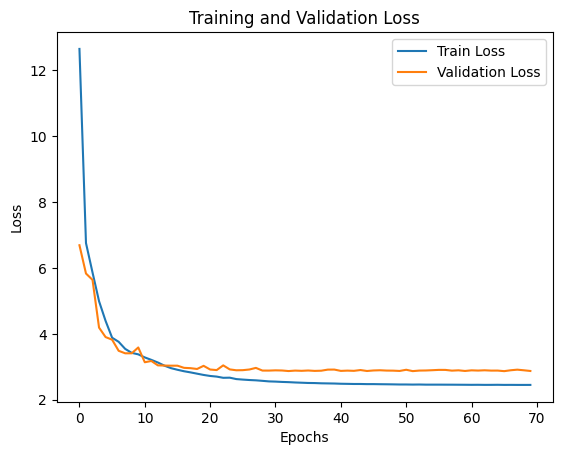

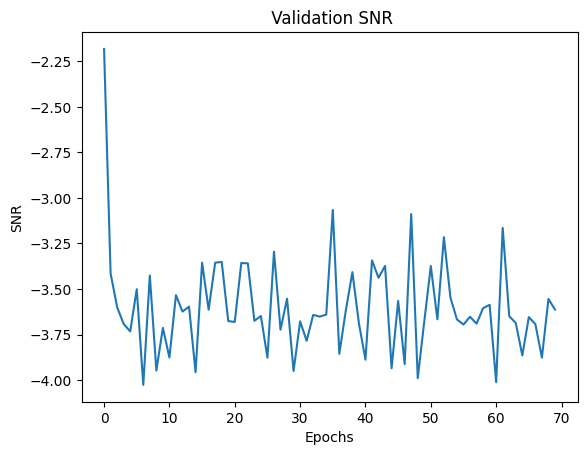

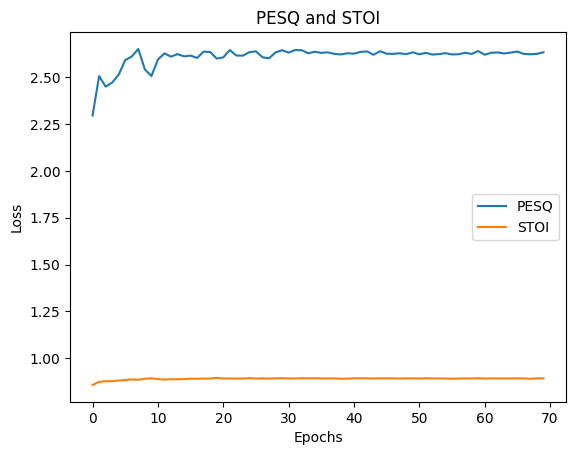

In [ ]:
#bluid train loop
from torch import nn
from train_unet import train
from model import My_unet

model= My_unet(in_channels=1, out_channels=1)
checkpoint= torch.load('/content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint_ep_48.pth')
model.load_state_dict(checkpoint)

loss= nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1)
scheduler= torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

nepochs= 70
batch_size= 1
save_dir= '/content/drive/MyDrive/Dlts_project/checkpoints_3'
os.makedirs(save_dir, exist_ok= True)
train_losses, val_losses, snr_values, val_pesq_scores, val_stoi_scores= train(model, data_path='/content/data/data/train/', batch_size= 8, n_epochs= nepochs, transform=transform, save_dir=save_dir)

# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(snr_values, label='SNR values')
plt.xlabel('Epochs')
plt.ylabel('SNR')
plt.title(' Validation SNR')
plt.show()


plt.plot(val_pesq_scores, label='PESQ')
plt.plot(val_stoi_scores, label='STOI')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('PESQ and STOI')
plt.legend()
plt.show()

In [ ]:
from torch import nn
from test_unet import test
from model import My_unet
model= My_unet(in_channels=1, out_channels=1)
#uber
nepochs= 5
batch_size= 1
save_dir= '/content/drive/MyDrive/Dlts_project/results_3'
os.makedirs(save_dir, exist_ok= True)
test(model, data_path='data/data/test/',checkpoint_path='/content/drive/MyDrive/Dlts_project/checkpoints_3/checkpoint.pth', batch_size= batch_size, transform=transform, save_dir=save_dir)

Loading the data...
Device: cuda


  0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 1/782 [00:01<24:53,  1.91s/it]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCro

Test Loss: 27.0385, Average SNR: 3.9733, Average PESQ: 2.6418, Average STOI: 0.8930
saved result dict !


(27.03845822048919, 3.973318364127786, 2.641825606908335, 0.8930268376074788)

original signal


noisy signal


retreived signal


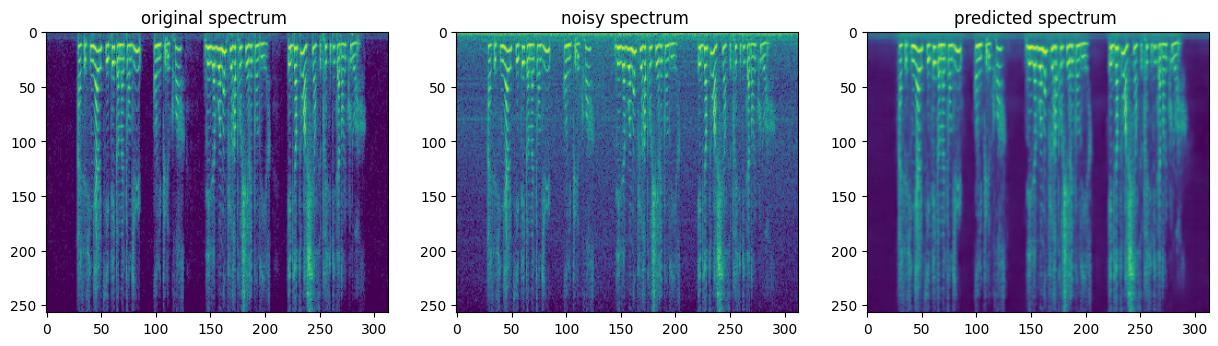

In [ ]:
import pickle
from data import retreive_sig
result_dict_path= '/content/drive/MyDrive/Dlts_project/results_3/result_dict.pickle'
data_path='/content/data/data/test/'

read_results(result_dict_path= result_dict_path, data_path= data_path)

<h3>Train 3:</h3>

Anoher intuition we had is that, although spectrograms are represented as image, they do not carry the same information as other images of object or landscapes for example, since in spectrograms analysis the infromation usually lies in the x-axis for time or y-axis for frequency,
which is very different from normal images where the position of the pixel observed is generally not so important, this justifies the fact that we could not apply any data augmentationt technique as rotation and cropping as is usually done in other image processing piplines. In this context, instead of applying square filters in the convolution layers, we use filters that have a rectangular shape and build the architecture of the contracting path inspired from the MCNN (Modified CNN) network:
![Unet Architecture](https://drive.google.com/uc?export=view&id=1oAsRZW8siHerhNrBV3uoH8UQhfsT42-4)





Loading the data...
Device: cuda

 start training


  0%|          | 0/50 [00:00<?, ?it/s]

checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_0.pth


  2%|▏         | 1/50 [15:28<12:38:00, 928.18s/it]

Epoch 1, Train Loss: 942.4481, Validation Loss: 67.9359, Average PESQ: 2.2821, Average STOI: 0.8271
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_1.pth


  4%|▍         | 2/50 [30:53<12:20:58, 926.23s/it]

Epoch 2, Train Loss: 67.1951, Validation Loss: 74.1777, Average PESQ: 2.4941, Average STOI: 0.8415
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_2.pth


  6%|▌         | 3/50 [46:17<12:04:49, 925.30s/it]

Epoch 3, Train Loss: 61.6836, Validation Loss: 77.7501, Average PESQ: 2.3969, Average STOI: 0.8646
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_3.pth


  8%|▊         | 4/50 [1:01:39<11:48:33, 924.20s/it]

Epoch 4, Train Loss: 60.0048, Validation Loss: 56.1267, Average PESQ: 2.4051, Average STOI: 0.8584
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_4.pth


 10%|█         | 5/50 [1:17:01<11:32:33, 923.40s/it]

Epoch 5, Train Loss: 57.5109, Validation Loss: 54.1264, Average PESQ: 2.6137, Average STOI: 0.8604
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_5.pth


 12%|█▏        | 6/50 [1:32:26<11:17:24, 923.73s/it]

Epoch 6, Train Loss: 55.7221, Validation Loss: 57.5656, Average PESQ: 2.5057, Average STOI: 0.8582
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_6.pth


 14%|█▍        | 7/50 [1:47:48<11:01:43, 923.34s/it]

Epoch 7, Train Loss: 54.5392, Validation Loss: 49.8462, Average PESQ: 2.5828, Average STOI: 0.8593
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_7.pth


 16%|█▌        | 8/50 [2:03:11<10:46:08, 923.05s/it]

Epoch 8, Train Loss: 53.4155, Validation Loss: 49.2341, Average PESQ: 2.6126, Average STOI: 0.8682
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_8.pth


 18%|█▊        | 9/50 [2:18:31<10:30:11, 922.22s/it]

Epoch 9, Train Loss: 52.7290, Validation Loss: 54.6312, Average PESQ: 2.5669, Average STOI: 0.8598
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_9.pth


 20%|██        | 10/50 [2:33:49<10:14:00, 921.01s/it]

Epoch 10, Train Loss: 51.4621, Validation Loss: 50.7515, Average PESQ: 2.5647, Average STOI: 0.8639
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_10.pth


 22%|██▏       | 11/50 [2:49:07<9:58:05, 920.14s/it] 

Epoch 11, Train Loss: 50.9153, Validation Loss: 51.9245, Average PESQ: 2.5800, Average STOI: 0.8671
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_11.pth


 24%|██▍       | 12/50 [3:04:26<9:42:29, 919.74s/it]

Epoch 12, Train Loss: 49.9669, Validation Loss: 53.0891, Average PESQ: 2.5987, Average STOI: 0.8745
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_12.pth


 26%|██▌       | 13/50 [3:19:45<9:27:04, 919.57s/it]

Epoch 13, Train Loss: 49.5848, Validation Loss: 52.2379, Average PESQ: 2.5294, Average STOI: 0.8748
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_13.pth


 28%|██▊       | 14/50 [3:35:06<9:11:58, 919.95s/it]

Epoch 14, Train Loss: 49.4041, Validation Loss: 51.0836, Average PESQ: 2.5987, Average STOI: 0.8737
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_14.pth


 30%|███       | 15/50 [3:50:28<8:56:53, 920.39s/it]

Epoch 15, Train Loss: 48.1024, Validation Loss: 51.4184, Average PESQ: 2.6335, Average STOI: 0.8734
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_15.pth


 32%|███▏      | 16/50 [4:05:49<8:41:47, 920.81s/it]

Epoch 16, Train Loss: 47.5100, Validation Loss: 53.4725, Average PESQ: 2.5997, Average STOI: 0.8746
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_16.pth


 34%|███▍      | 17/50 [4:21:08<8:26:07, 920.21s/it]

Epoch 17, Train Loss: 47.4769, Validation Loss: 46.9314, Average PESQ: 2.6654, Average STOI: 0.8749
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_17.pth


 36%|███▌      | 18/50 [4:36:26<8:10:24, 919.53s/it]

Epoch 18, Train Loss: 46.9976, Validation Loss: 45.8061, Average PESQ: 2.6488, Average STOI: 0.8749
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_18.pth


 38%|███▊      | 19/50 [4:51:44<7:54:51, 919.09s/it]

Epoch 19, Train Loss: 46.7218, Validation Loss: 47.8976, Average PESQ: 2.6345, Average STOI: 0.8697
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_19.pth


 40%|████      | 20/50 [5:07:02<7:39:23, 918.79s/it]

Epoch 20, Train Loss: 46.2084, Validation Loss: 46.3556, Average PESQ: 2.6327, Average STOI: 0.8717
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_20.pth


 42%|████▏     | 21/50 [5:22:19<7:23:48, 918.22s/it]

Epoch 21, Train Loss: 46.0198, Validation Loss: 45.3418, Average PESQ: 2.6370, Average STOI: 0.8748
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_21.pth


 44%|████▍     | 22/50 [5:37:35<7:08:12, 917.60s/it]

Epoch 22, Train Loss: 45.4970, Validation Loss: 45.1689, Average PESQ: 2.5687, Average STOI: 0.8773
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_22.pth


 46%|████▌     | 23/50 [5:52:56<6:53:21, 918.57s/it]

Epoch 23, Train Loss: 45.3756, Validation Loss: 46.3590, Average PESQ: 2.6033, Average STOI: 0.8700
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_23.pth


 48%|████▊     | 24/50 [6:08:12<6:37:44, 917.85s/it]

Epoch 24, Train Loss: 45.2691, Validation Loss: 44.7805, Average PESQ: 2.6388, Average STOI: 0.8751
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_24.pth


 50%|█████     | 25/50 [6:23:28<6:22:10, 917.22s/it]

Epoch 25, Train Loss: 45.1834, Validation Loss: 44.8433, Average PESQ: 2.6957, Average STOI: 0.8764
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_25.pth


 52%|█████▏    | 26/50 [6:38:44<6:06:42, 916.76s/it]

Epoch 26, Train Loss: 44.7963, Validation Loss: 45.0246, Average PESQ: 2.6272, Average STOI: 0.8778
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_26.pth


 54%|█████▍    | 27/50 [6:53:58<5:51:07, 915.98s/it]

Epoch 27, Train Loss: 44.6666, Validation Loss: 45.7780, Average PESQ: 2.6581, Average STOI: 0.8741
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_27.pth


 56%|█████▌    | 28/50 [7:09:13<5:35:42, 915.57s/it]

Epoch 28, Train Loss: 44.6019, Validation Loss: 44.6059, Average PESQ: 2.6337, Average STOI: 0.8775
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_28.pth


 58%|█████▊    | 29/50 [7:24:28<5:20:27, 915.62s/it]

Epoch 29, Train Loss: 44.4046, Validation Loss: 44.4742, Average PESQ: 2.6710, Average STOI: 0.8750
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_29.pth


 60%|██████    | 30/50 [7:39:44<5:05:11, 915.59s/it]

Epoch 30, Train Loss: 44.1968, Validation Loss: 44.8652, Average PESQ: 2.6407, Average STOI: 0.8771
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_30.pth


 62%|██████▏   | 31/50 [7:54:59<4:49:51, 915.34s/it]

Epoch 31, Train Loss: 44.0168, Validation Loss: 48.4499, Average PESQ: 2.5862, Average STOI: 0.8781


 64%|██████▍   | 32/50 [8:10:12<4:34:27, 914.84s/it]

Epoch 32, Train Loss: 44.0752, Validation Loss: 45.8421, Average PESQ: 2.6386, Average STOI: 0.8796
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_32.pth


 66%|██████▌   | 33/50 [8:25:27<4:19:12, 914.85s/it]

Epoch 33, Train Loss: 43.8759, Validation Loss: 45.6155, Average PESQ: 2.6298, Average STOI: 0.8798


 68%|██████▊   | 34/50 [8:40:43<4:04:01, 915.08s/it]

Epoch 34, Train Loss: 43.8877, Validation Loss: 44.7676, Average PESQ: 2.6912, Average STOI: 0.8760
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_34.pth


 70%|███████   | 35/50 [8:56:00<3:48:55, 915.71s/it]

Epoch 35, Train Loss: 43.8186, Validation Loss: 45.7159, Average PESQ: 2.6046, Average STOI: 0.8792
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_35.pth


 72%|███████▏  | 36/50 [9:11:17<3:33:45, 916.08s/it]

Epoch 36, Train Loss: 43.6753, Validation Loss: 44.1100, Average PESQ: 2.6731, Average STOI: 0.8760
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_36.pth


 74%|███████▍  | 37/50 [9:26:34<3:18:31, 916.26s/it]

Epoch 37, Train Loss: 43.6454, Validation Loss: 44.1054, Average PESQ: 2.6519, Average STOI: 0.8777
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_37.pth


 76%|███████▌  | 38/50 [9:41:50<3:03:15, 916.32s/it]

Epoch 38, Train Loss: 43.5775, Validation Loss: 44.1664, Average PESQ: 2.6378, Average STOI: 0.8776
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_38.pth


 78%|███████▊  | 39/50 [9:57:07<2:48:01, 916.51s/it]

Epoch 39, Train Loss: 43.5356, Validation Loss: 44.0198, Average PESQ: 2.6402, Average STOI: 0.8764
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_39.pth


 80%|████████  | 40/50 [10:12:23<2:32:43, 916.38s/it]

Epoch 40, Train Loss: 43.4489, Validation Loss: 44.4681, Average PESQ: 2.6426, Average STOI: 0.8791
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_40.pth


 82%|████████▏ | 41/50 [10:27:40<2:17:28, 916.47s/it]

Epoch 41, Train Loss: 43.4236, Validation Loss: 44.1141, Average PESQ: 2.6467, Average STOI: 0.8783
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_41.pth


 84%|████████▍ | 42/50 [10:42:58<2:02:15, 916.93s/it]

Epoch 42, Train Loss: 43.3589, Validation Loss: 43.9483, Average PESQ: 2.6546, Average STOI: 0.8777
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_42.pth


 86%|████████▌ | 43/50 [10:58:15<1:46:59, 917.13s/it]

Epoch 43, Train Loss: 43.3344, Validation Loss: 44.1309, Average PESQ: 2.6615, Average STOI: 0.8782
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_43.pth


 88%|████████▊ | 44/50 [11:13:34<1:31:44, 917.49s/it]

Epoch 44, Train Loss: 43.2981, Validation Loss: 43.9479, Average PESQ: 2.6568, Average STOI: 0.8770
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_44.pth


 90%|█████████ | 45/50 [11:28:51<1:16:26, 917.33s/it]

Epoch 45, Train Loss: 43.2461, Validation Loss: 44.1478, Average PESQ: 2.6385, Average STOI: 0.8782
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_45.pth


 92%|█████████▏| 46/50 [11:44:09<1:01:10, 917.52s/it]

Epoch 46, Train Loss: 43.2280, Validation Loss: 44.1544, Average PESQ: 2.6503, Average STOI: 0.8783
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_46.pth


 94%|█████████▍| 47/50 [11:59:26<45:52, 917.49s/it]  

Epoch 47, Train Loss: 43.1892, Validation Loss: 43.8648, Average PESQ: 2.6486, Average STOI: 0.8771
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_47.pth


 96%|█████████▌| 48/50 [12:14:43<30:34, 917.29s/it]

Epoch 48, Train Loss: 43.1859, Validation Loss: 43.8568, Average PESQ: 2.6631, Average STOI: 0.8772
checkpoint saved at:  /content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_48.pth


 98%|█████████▊| 49/50 [12:30:00<15:17, 917.12s/it]

Epoch 49, Train Loss: 43.1457, Validation Loss: 43.9770, Average PESQ: 2.6465, Average STOI: 0.8777


100%|██████████| 50/50 [12:45:15<00:00, 918.31s/it]

Epoch 50, Train Loss: 43.1636, Validation Loss: 43.8327, Average PESQ: 2.6479, Average STOI: 0.8770


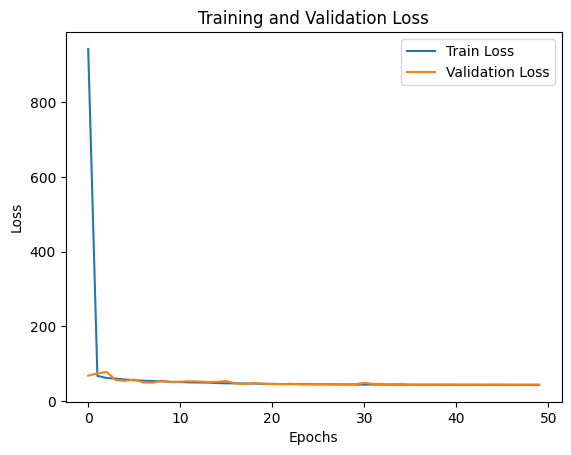

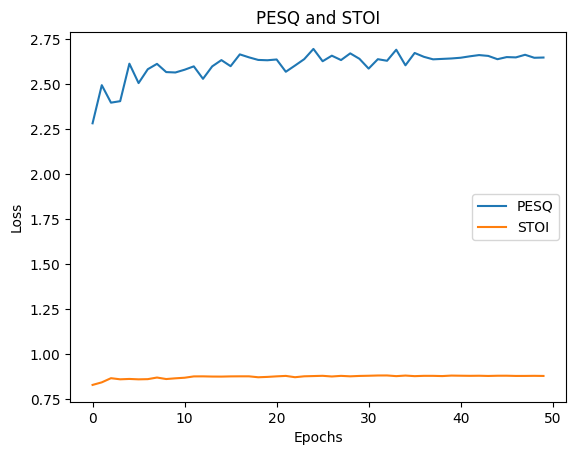

In [ ]:
#bluid train loop
from torch import nn
from train_unet import train
from model_2 import My_unet_2
model= My_unet_2(in_channels=1, out_channels=1)

loss= nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1)
scheduler= torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

nepochs= 50
batch_size= 1
save_dir= '/content/drive/MyDrive/Dlts_project/checkpoints_2'
os.makedirs(save_dir, exist_ok= True)
train_losses, val_losses, val_pesq_scores, val_stoi_scores= train(model, data_path='/content/data/data/train/', batch_size= batch_size, n_epochs= nepochs, transform=transform, save_dir=save_dir)

# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
plt.plot(val_pesq_scores, label='PESQ')
plt.plot(val_stoi_scores, label='STOI')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('PESQ and STOI')
plt.legend()
plt.show()

In [ ]:
from torch import nn
from test_unet import test
from model_2 import My_unet_2
model= My_unet_2(in_channels=1, out_channels=1)
#uber
nepochs= 5
batch_size= 1
save_dir= '/content/drive/MyDrive/Dlts_project/results_2'
os.makedirs(save_dir, exist_ok= True)
test(model, data_path='data/data/test/',checkpoint_path='/content/drive/MyDrive/Dlts_project/checkpoints_2/checkpoint_ep_48.pth', batch_size= batch_size, transform=transform, save_dir=save_dir)

Loading the data...
Device: cuda


100%|██████████| 782/782 [05:10<00:00,  2.52it/s]


Test Loss: 42.3163, Average SNR: 3.5387, Average PESQ: 2.6786, Average STOI: 0.8811
saved result dict !


(42.31626730440828, 3.538666726709671, 2.678558842300454, 0.8811462860354378)

original signal


noisy signal


retreived signal


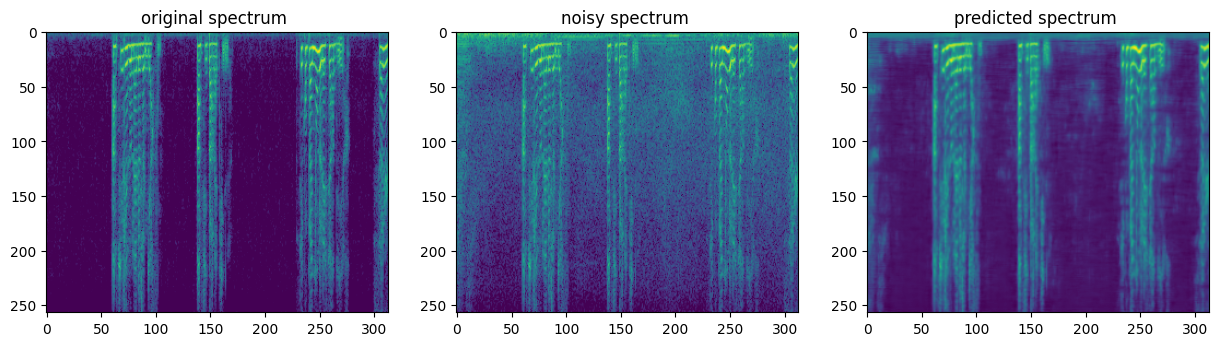

In [ ]:
import pickle
from data import retreive_sig
result_dict_path= '/content/drive/MyDrive/Dlts_project/results_2/result_dict.pickle'
data_path='/content/data/data/test/'
read_results(result_dict_path= result_dict_path, data_path= data_path)

<h2> Denoising spectrograms, traditional method: </h2>
We have also explored, much simpler approaches than deep neural networks to perform denoising give the spectrogram data, for comparison purposes.

We implement and test the **Morphological Filtering** method, which is based on the two fundamental operations of Erosion and Dilation, where  erosion selectively reduces less significant details, effectively removing noise. Dilation complements erosion by enhancing important features. Together, they create a non-linear, time-frequency filter that removes noise while preserving audio signal components.


In [ ]:
def morph_denoise(Zxx,threshold,amp):

  zmax=(np.max(np.abs(Zxx)))

  gray_image=20 * np.log10(np.abs(Zxx*(255/zmax)))

  thresh_image=np.where(gray_image>=threshold,1,0)# binary thresholding

  mask_image = binary_erosion(thresh_image,iterations=1)
  mask_image = binary_dilation(mask_image,iterations=2)

  figure ,axis_arr = plt.subplots(1,3)
  plt.rcParams['figure.figsize']=[15,10]
  plt.rcParams.update({'font.size':10})
  axis_arr[0].set_title("grayscale spectrogram")
  axis_arr[0].imshow(gray_image)
  axis_arr[1].set_title("After binary thresholding")
  axis_arr[1].imshow(thresh_image)
  axis_arr[2].set_title("After Morphological filtering")
  axis_arr[2].imshow(mask_image)
  Rxx = np.where(mask_image==1,Zxx*amp ,Zxx/amp)

  return Rxx


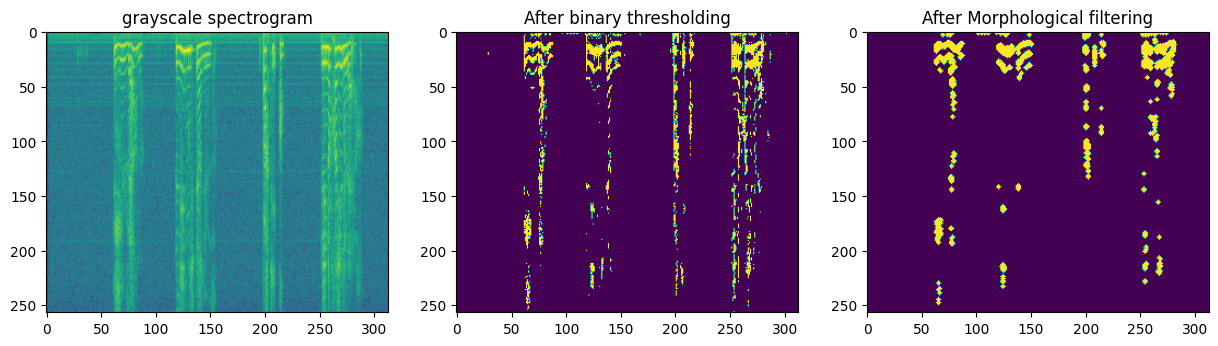

In [ ]:
Rxx=morph_denoise(magnitude,threshold=0.6,amp=10)


The image we process looks different from the spectrogram because the axis are flipped(image indices start from 0 from the top). But that doesn't affect the processing.

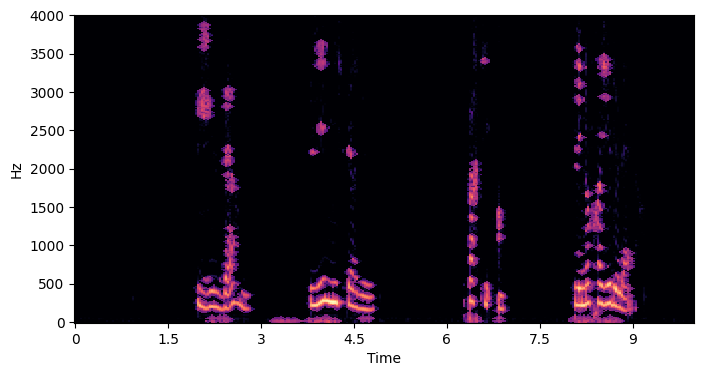

In [ ]:
draw_spectrogram(sr,Rxx,hop_length_fft)

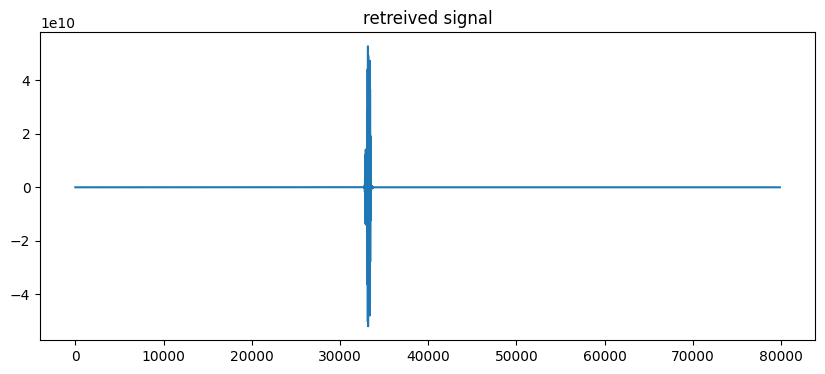

(79872,)


In [ ]:
from data import retreive_sig
fs= 8000
audio_retrieved= retreive_sig(Rxx, phase, n_fft, hop_length_fft)
plt.figure(figsize=(10,4))
plt.plot(audio_retrieved)
plt.title('retreived signal')
plt.show()

display(ipd.Audio(data= audio_retrieved, rate= fs))
print(audio_retrieved.shape)

<h2>METHOD 2: Perform denoising on the Time Domain Signals (Waveforms)</h2>

<h2>Wave U-Net Architecture</h2>


Wave-U-Net [1] is an extension of the U-Net architecture that operates directly on waveforms. Instead of 2D convolutions/deconvolutions acting on a spectrogram, Wave-U-Nets have a series of 1D convolutions/deconvolutions that operate on audio directly. Just like the spectrogram U-Net though, the convolutional encoding layers are concatenated with the corresponding deconvolutional decoding layers.

Wave-U-Net uses MSE loss between the target and estimated waveforms.

[1] *Daniel Stoller, Sebastian Ewert, and Simon Dixon. Wave-u-net: a multi-scale neural network for end-to-end audio source separation. arXiv preprint arXiv:1806.03185, 2018.*

![Wave U-net Architecture](https://drive.google.com/uc?id=1rEhe9xHqCR-6B5f7rkiGibJ1srNqKnO1)

<h4>Model</h4>

In [ ]:
class DownSamplingLayer(nn.Module):
    def __init__(self, channel_in, channel_out, dilation=1, kernel_size=15, stride=1, padding=7):
        super(DownSamplingLayer, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(channel_in, channel_out, kernel_size=kernel_size,
                      stride=stride, padding=padding, dilation=dilation),
            nn.BatchNorm1d(channel_out),
            nn.LeakyReLU(negative_slope=0.1)
        )

    def forward(self, ipt):
        return self.main(ipt)

class UpSamplingLayer(nn.Module):
    def __init__(self, channel_in, channel_out, kernel_size=5, stride=1, padding=2):
        super(UpSamplingLayer, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(channel_in, channel_out, kernel_size=kernel_size,
                      stride=stride, padding=padding),
            nn.BatchNorm1d(channel_out),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
        )

    def forward(self, ipt):
        return self.main(ipt)

class Model(nn.Module):
    def __init__(self, n_layers=6, channels_interval=24):
        super(Model, self).__init__()

        self.n_layers = n_layers
        self.channels_interval = channels_interval
        encoder_in_channels_list = [1] + [i * self.channels_interval for i in range(1, self.n_layers)]
        encoder_out_channels_list = [i * self.channels_interval for i in range(1, self.n_layers + 1)]

        #     0 =>     1 =>     2 =>     3 =>    4 =>    5 =>    6 =>   7
        # 80000 => 40000 => 20000 => 10000 => 5000 => 2500 => 1250 => 625

            # Second approach, patches as input
        #     0 =>     1 =>     2 =>    3 =>    4 =>    5 =>    6
        # 40000 => 20000 => 10000 => 5000 => 2500 => 1250 =>  625

        self.encoder = nn.ModuleList()

        for i in range(self.n_layers):
            self.encoder.append(
                DownSamplingLayer(
                    channel_in=encoder_in_channels_list[i],
                    channel_out=encoder_out_channels_list[i]
                )
            )

        self.middle = nn.Sequential(
            nn.Conv1d(self.n_layers * self.channels_interval, self.n_layers * self.channels_interval, 15, stride=1,
                      padding=7),
            nn.BatchNorm1d(self.n_layers * self.channels_interval),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )

        #
        decoder_in_channels_list = [(2 * i + 1) * self.channels_interval for i in range(1, self.n_layers)] + [
            2 * self.n_layers * self.channels_interval]
        decoder_in_channels_list = decoder_in_channels_list[::-1]
        decoder_out_channels_list = encoder_out_channels_list[::-1]
        self.decoder = nn.ModuleList()
        for i in range(self.n_layers):
            self.decoder.append(
                UpSamplingLayer(
                    channel_in=decoder_in_channels_list[i],
                    channel_out=decoder_out_channels_list[i]
                )
            )

        self.out = nn.Sequential(
            nn.Conv1d(1 + self.channels_interval, 1, kernel_size=1, stride=1),
            nn.Tanh()
        )
    def forward(self, input):
        tmp = []
        #------------------------------------- INPUT
        o = input
        # ---------------------------------- DOWNSAMPLING
        for i in range(self.n_layers):
            o = self.encoder[i](o)
            tmp.append(o)
            o = o[:, :, ::2]
        #------------------------------------ MIDDLE (BOTTLENECK)
        o = self.middle(o)
        #---------------------------------- UPSAMPLING
        for i in range(self.n_layers):
            o = F.interpolate(o, scale_factor=2, mode="linear", align_corners=True)
            # Skip Connection
            o = torch.cat([o, tmp[self.n_layers - i - 1]], dim=1)
            o = self.decoder[i](o)
        #---------------------------------COMBINE WITH INPUT and OUT
        o = torch.cat([o, input], dim=1)
        o = self.out(o)
        return o

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

Using device: cuda


Model(
  (encoder): ModuleList(
    (0): DownSamplingLayer(
      (main): Sequential(
        (0): Conv1d(1, 24, kernel_size=(15,), stride=(1,), padding=(7,))
        (1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
    )
    (1): DownSamplingLayer(
      (main): Sequential(
        (0): Conv1d(24, 48, kernel_size=(15,), stride=(1,), padding=(7,))
        (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
    )
    (2): DownSamplingLayer(
      (main): Sequential(
        (0): Conv1d(48, 72, kernel_size=(15,), stride=(1,), padding=(7,))
        (1): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
    )
    (3): DownSamplingLayer(
      (main): Sequential(
        (0): Conv1d(72, 96, kernel_size=(15,), stride=(1,), padding=(7,))
       

<h4>Custom Dataset class</h4>

Utility functions to preprocess the signals :
* ``divide_into_patches_and_save(audio_path, patch_size, target_directory)`` : function to divide the audio signal into patches
* ``scale_signal(signal)`` : function to scale both input and target signal into the same scale

In [ ]:
class Wave_Dataset(Dataset):
    def __init__(self, data_path, patch_size=None, split=None, p=1.0):
        """Construct dataset for training and validation.
        Args:
            data_path (str): directory path, containing all signal wavfiles (train or test).
            patch_size (None/int): if not None, we divide each signal into equal length patches
            split (str): "train"/"val"/None to get subsets of train data
            p (float): if split is not None, p is proportion of train samples, 1-p is proportion of validation samples
        Return:
            (noisy signal, clean signal, filename)
        """
        print(f"Loading data from {data_path}: ")
        super(Dataset, self).__init__()
        self.data_path = data_path
        self.patch_size = patch_size
        self.split = split

        print("\tLoading clean data...")
        clean_folder = os.path.join(self.data_path, "original/signal")
        self.clean_data = list(map(lambda x:os.path.join(clean_folder, x), os.listdir(clean_folder)))

        print("\tLoading noisy data...")
        noisy_folder = os.path.join(self.data_path, "noisy/signal")
        self.noisy_data = list(map(lambda x:os.path.join(noisy_folder, x), os.listdir(noisy_folder)))
        print(f"\tdata loaded.")

        if patch_size :
            self.clean_data, self.noisy_data = self._make_patches()

        assert len(self.clean_data) == len(self.noisy_data)
        if split :
            limit = int(len(self.clean_data)*p)
            if split == 'train':
                self.clean_data = self.clean_data[:limit]
                self.noisy_data = self.noisy_data[:limit]
                print(len(self.noisy_data))
            if split == 'val':
                self.clean_data = self.clean_data[limit:]
                self.noisy_data = self.noisy_data[limit:]
                print(len(self.noisy_data))

    def _make_patches(self):
        if "train" in self.data_path: #train or val
            if self.split=='val':
                target_dir = 'processed/val/'
                print('loading val')
            else:
                target_dir = 'processed/train/'
                print('loading train')
        else:
            target_dir = 'processed/test/'
            print('loading test')
        clean_data_processed = []
        noisy_data_processed = []
        for i in range(len(self.noisy_data)):
            clean_abs_path, noisy_abs_path = self.clean_data[i], self.noisy_data[i]
            clean_patches = divide_into_patches_and_save(clean_abs_path, self.patch_size, target_dir+'original/')
            noisy_patches = divide_into_patches_and_save(noisy_abs_path, self.patch_size, target_dir+'noisy/')
            clean_data_processed += clean_patches
            noisy_data_processed += noisy_patches
        return clean_data_processed, noisy_data_processed

    def __len__(self):
        return len(self.noisy_data)

    def __getitem__(self, idx):
        clean_path, noisy_path = self.clean_data[idx], self.noisy_data[idx]
        filename = os.path.splitext(os.path.basename(noisy_path))[0]
        _, clean = wavfile.read(clean_path)
        _, noisy = wavfile.read(noisy_path)
        clean_scaled = scale_signal(clean)
        noisy_scaled = scale_signal(noisy)
        return noisy_scaled.reshape(1, -1), clean_scaled.reshape(1, -1), filename

In [ ]:
train_dataset = Wave_Dataset(train_path, patch_size=40000, split='train', p=0.9)
val_dataset = Wave_Dataset(train_path,patch_size=40000, split='val', p=0.9)
test_dataset = Wave_Dataset(test_path, patch_size=40000)

<h4>Training and testing</h4>

In [ ]:
seed = 0
epochs = 50
best_val_loss = 100000
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

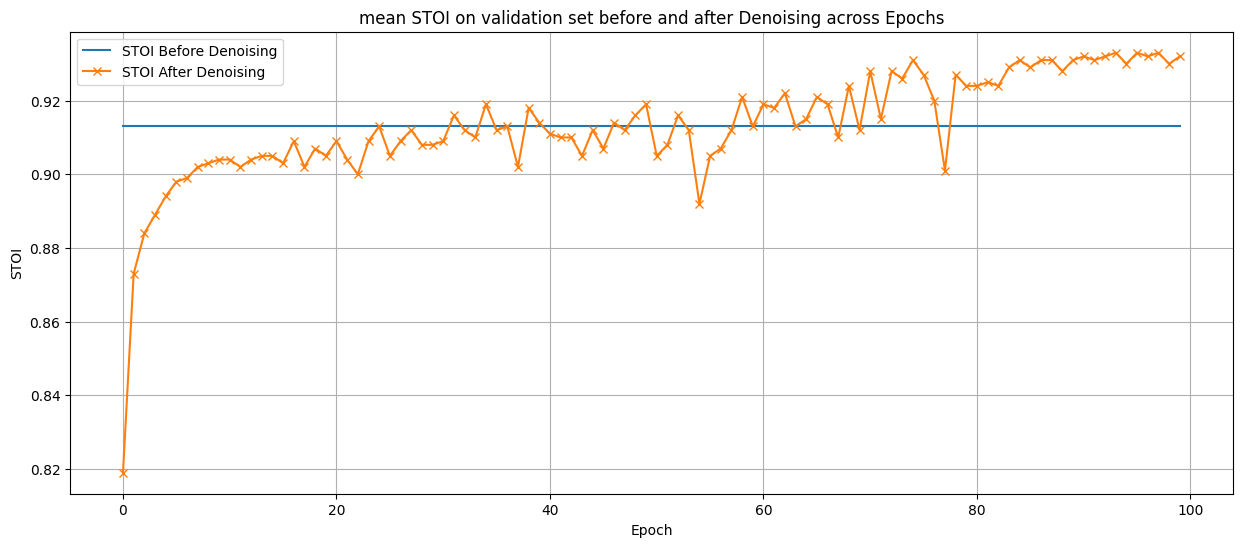

<Figure size 640x480 with 0 Axes>

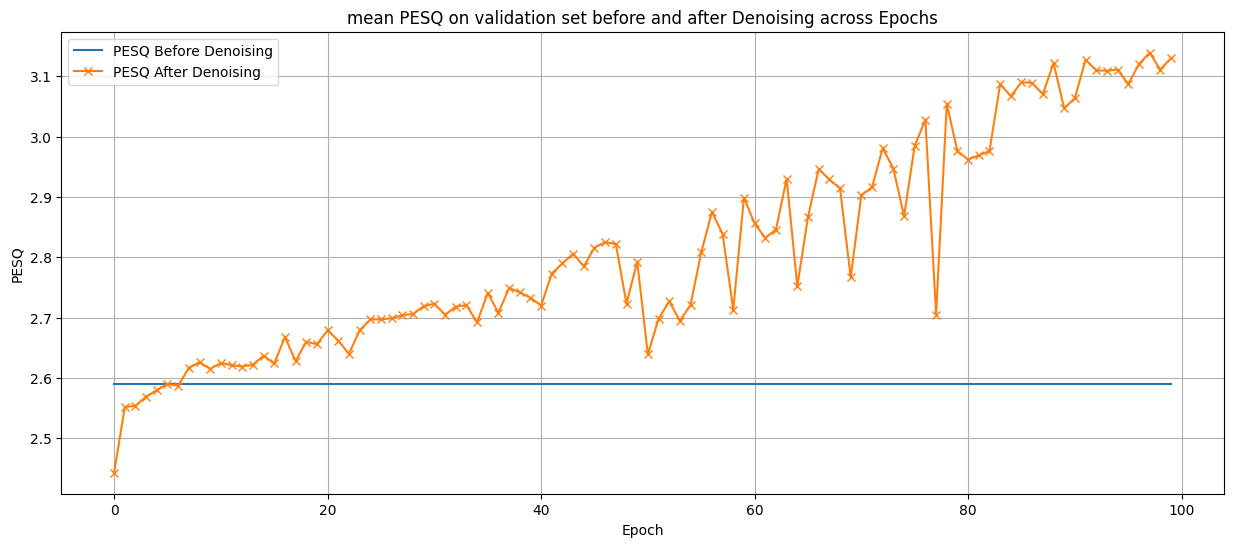

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plotting STOI
plt.figure(figsize=(15, 6))
plt.plot(epochs, stoi_before, label='STOI Before Denoising')
plt.plot(epochs, stoi_after, label='STOI After Denoising', marker='x')
plt.title('mean STOI on validation set before and after Denoising across Epochs')
plt.xlabel('Epoch')
plt.ylabel('STOI')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('STOI_before_after.png')

# Plotting PESQ
plt.figure(figsize=(15, 6))
plt.plot(epochs, pesq_before, label='PESQ Before Denoising')
plt.plot(epochs, pesq_after, label='PESQ After Denoising', marker='x')
plt.title('mean PESQ on validation set before and after Denoising across Epochs')
plt.xlabel('Epoch')
plt.ylabel('PESQ')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('PESQ_before_after.png')


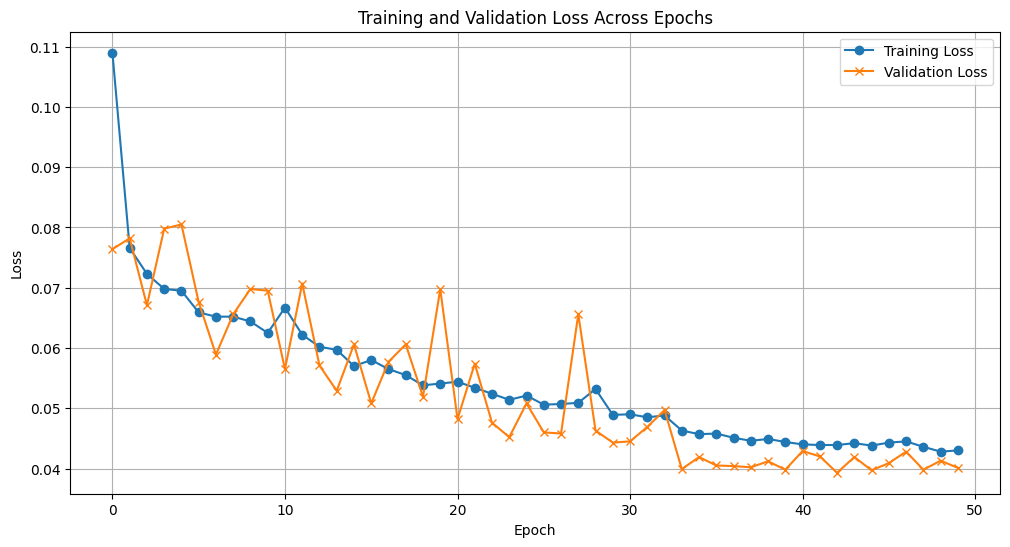

In [ ]:
epochs = list(range(50))

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='x')
plt.title('Training and Validation Loss Across Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


STOI before denoising : 0.906, STOI after : 0.929
PESQ before denoising : 2.466, PESQ after : 3.026


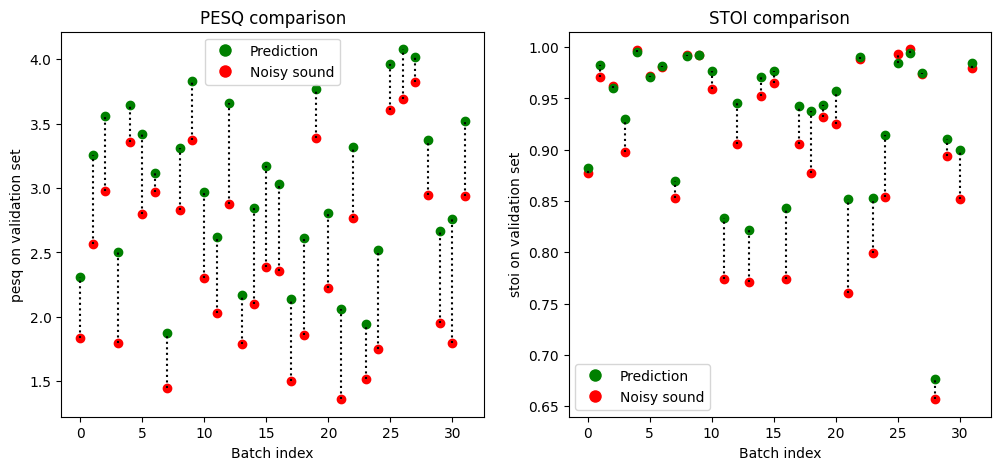


You can listen to one element in the batch (chosen randomly) using the widgets below.

Noisy signal




Target signal




Denoised signal



<Figure size 640x480 with 0 Axes>

In [ ]:
from matplotlib.lines import Line2D
for i_, (noisy, clean, name) in enumerate(test_loader):
        noisy = noisy.to(device)
        clean = clean.to(device)
        enhanced = model(noisy).to(device)

        clean_np = clean.detach().cpu().numpy()
        enhanced_np = enhanced.detach().cpu().numpy()
        noisy_np = noisy.detach().cpu().numpy()

        # Compute PESQ and STOI for each sample in the batch

        batch_pesq_cn = [] #cn : clean vs noisy
        batch_pesq_ce = [] #ce : clean vs enhanced

        batch_stoi_cn = []
        batch_stoi_ce = []

        for i in range(clean_np.shape[0]):
            pesq_ce = compute_PESQ(clean_np[i].squeeze(), enhanced_np[i].squeeze())
            batch_pesq_ce.append(pesq_ce)
            pesq_cn = compute_PESQ(clean_np[i].squeeze(), noisy_np[i].squeeze())
            batch_pesq_cn.append(pesq_cn)

            stoi_ce = compute_STOI(clean_np[i].squeeze(), enhanced_np[i].squeeze())
            batch_stoi_ce.append(stoi_ce)
            stoi_cn = compute_STOI(clean_np[i].squeeze(), noisy_np[i].squeeze())
            batch_stoi_cn.append(stoi_cn)
            # plotting the metrics
        print(f'STOI before denoising : {np.mean(batch_stoi_cn):.3f}, STOI after : {np.mean(batch_stoi_ce):.3f}')
        print(f'PESQ before denoising : {np.mean(batch_pesq_cn):.3f}, PESQ after : {np.mean(batch_pesq_ce):.3f}')

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        for i in range(noisy.shape[0]):
            ax1.scatter(i, batch_pesq_cn[i], c='r')
            ax1.scatter(i, batch_pesq_ce[i], c='g')
            ax1.vlines(i, ymin=min(batch_pesq_cn[i], batch_pesq_ce[i]),
               ymax=max(batch_pesq_cn[i], batch_pesq_ce[i]), color='black', linestyle=':')

            ax2.scatter(i, batch_stoi_cn[i], c='r')
            ax2.scatter(i, batch_stoi_ce[i], c='g')
            ax2.vlines(i, ymin=min(batch_stoi_cn[i], batch_stoi_ce[i]),
               ymax=max(batch_stoi_cn[i], batch_stoi_ce[i]), color='black', linestyle=':')
        legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Prediction', markerfacecolor='g', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Noisy sound', markerfacecolor='r', markersize=10)
        ]

        ax1.legend(handles=legend_elements)
        ax2.legend(handles=legend_elements)
        ax1.set(title="PESQ comparison", xlabel="Batch index", ylabel="pesq on validation set")
        ax2.set(title="STOI comparison", xlabel="Batch index", ylabel="stoi on validation set")

        plt.show()

        # direct comparison by ear
        idx = np.random.randint(0, batch_size - 1)

        print("\nYou can listen to one element in the batch (chosen randomly) using the widgets below.")
        print("\nNoisy signal\n")
        display(ipd.Audio(noisy_np[idx], rate=8000))
        print("\nTarget signal\n")
        display(ipd.Audio(clean_np[idx], rate=8000))
        print("\nDenoised signal\n")
        display(ipd.Audio(enhanced_np[idx], rate=8000))

        plt.savefig('inference.png')
        break


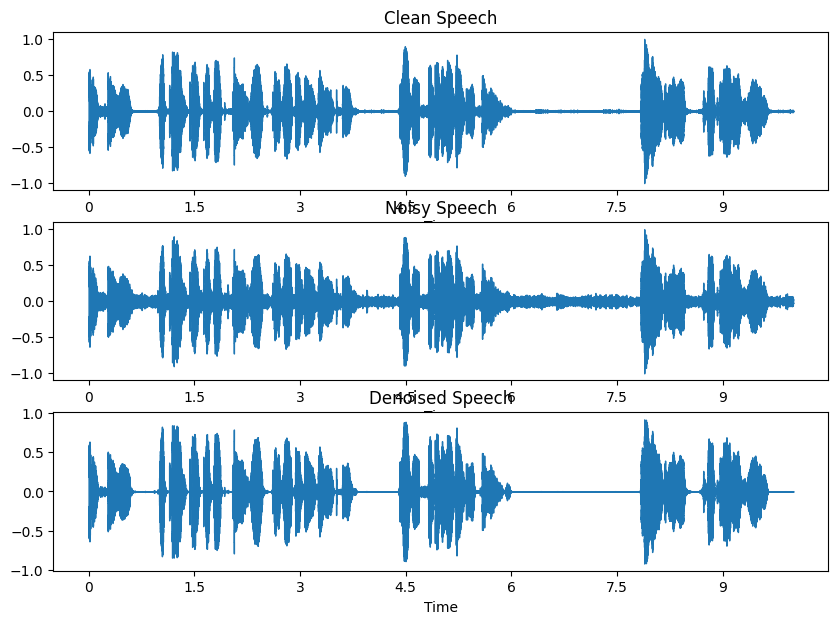

In [ ]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplot(311)
plt.title('Clean Speech')
librosa.display.waveshow(clean_np[idx].squeeze(), sr=8000)

# Plot noisy speech
plt.subplot(312)
plt.title('Noisy Speech')
librosa.display.waveshow(noisy_np[idx].squeeze(), sr=8000)

# Plot enhanced speech
plt.subplot(313)
plt.title('Denoised Speech')
librosa.display.waveshow(enhanced_np[idx].squeeze(), sr=8000)


<h2> Iterative Wiener Filtering</h2>

**Idea** : derive the enhanced signal by optimizing a mathematically tractable error criterion, the
mean-square error

Loizou, Philipos C. . Speech Enhancement: Theory and Practice. CRC Press, Inc. 2007. https://github.com/vipchengrui/traditional-speech-enhancement/blob/master/wiener_filtering_noise_estimation/wiener_filtering_noise_estimation.py


<ipython-input-78-808c3594429c>:22: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  clean = scale_signal(np.fromstring(str_data1, dtype=np.short))
<ipython-input-61-422b46d415e2>:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  low_1 = 2*np.ones(k_1khz,dtype=np.int),
<ipython-input-61-422b46d415e2>:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior

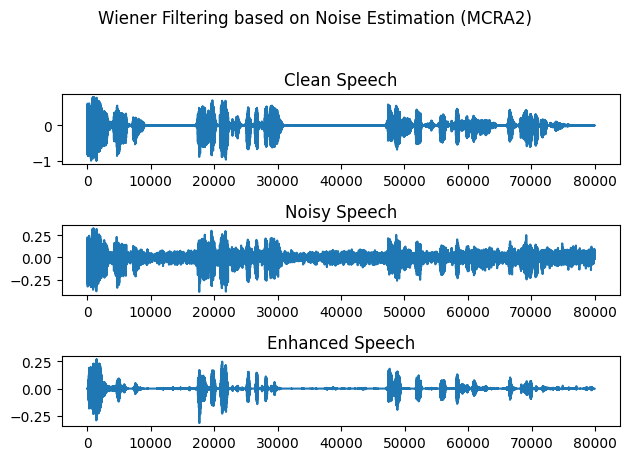

Clean :


Noisy :


Enhanced :


STOI before denoising : 0.883, STOI after : 0.721
PESQ before denoising : 2.006, PESQ after : 1.609


In [ ]:
import numpy as np
import wave
import matplotlib.pyplot as plt
import math
import os

# input wave file
clean_signals = os.listdir(train_small_path + 'original/signal/')
clean_signal = wave.open(train_small_path + 'original/signal/' + clean_signals[2])

# read format information
# (nchannels, sampwidth, framerate, nframes, comptype, compname)
params1 = clean_signal.getparams()
nchannels1, sampwidth1, framerate1, nframes1 = params1[:4]
fs1 = framerate1
# read wave data
str_data1 = clean_signal.readframes(nframes1)
# close .wav file
clean_signal.close()

# convert waveform data to an array
clean = scale_signal(np.fromstring(str_data1, dtype=np.short))

noisy_signals = os.listdir(train_small_path + 'noisy/signal/')
# Load the audio file using librosa
y, sr = librosa.load(train_small_path + 'noisy/signal/' + noisy_signals[2], sr=None)  # sr=None ensures the original sampling rate is used

# y is the waveform and sr is the sampling rate
# If you need the number of channels, sample width, frame rate, etc.
nframes = len(y)
framerate = sr
# close .wav file
clean_signal.close()

# convert waveform data to an array
x = y

# noisy speech FFT
x_FFT = abs(np.fft.fft(x))

# calculation parameters
len_ = 20 * fs // 1000      # frame size in samples
PERC = 50                   # window overlop in percent of frame
len1 = len_ * PERC // 100   # overlop'length
len2 = len_ - len1          # window'length - overlop'length

# setting default parameters
Thres = 3       # VAD threshold in dB SNRseg
Expnt = 2.0
beta = 0.002
G = 0.9

# hamming window
#win = np.hamming(len_)

# sine window
i = np.linspace(0,len_ - 1,len_)
win = np.sqrt(2/(len_ + 1)) * np.sin(np.pi * (i + 1) / (len_ + 1))

# normalization gain for overlap+add with 50% overlap
winGain = len2 / sum(win)

# nFFT = 2 * 2 ** (nextpow2.nextpow2(len_))
nFFT = 2 * 2 ** 8

# initialize various variables
k = 1
img = 1j
x_old = np.zeros(len1)
Nframes = len(x) // len2 - 1
xfinal = np.zeros(Nframes * len2)

# === Start Processing ==== #
for n in range(0, Nframes):

    # Windowing
    insign = win * x[k - 1 : k + len_ - 1]
    # compute fourier transform of a frame
    spec = np.fft.fft(insign, nFFT)
    # compute the magnitude
    sig = abs(spec)
    # noisy speech power spec
    ns_ps = sig ** 2
    # save the noisy phase information
    theta = np.angle(spec)

    # Noise Estimation
    #Init_Weight、ConMinTrack、MCRA、MCRA2
    if n == 0:
        para = Init_MCRA2(ns_ps,fs).info()
    else:
        para = Est_MCRA2(ns_ps,para).est()

    noise_ps = para['noise_ps']
    noise_mu = np.sqrt(noise_ps)

    # Posterior SNR
    SNRpos = 10 * np.log10(np.linalg.norm(sig, 2) ** 2 / np.linalg.norm(noise_mu, 2) ** 2)

    # --- wiener filtering --- #

    # setting SNR
    def berouti(SNR):
        if -5.0 <= SNR <= 20.0:
            a = 4 - SNR * 3 / 20
        else:
            if SNR < -5.0:
                a = 5
            if SNR > 20:
                a = 1
        return a
    def berouti1(SNR):
        if -5.0 <= SNR <= 20.0:
            a = 3 - SNR * 2 / 20
        else:
            if SNR < -5.0:
                a = 4
            if SNR > 20:
                a = 1
        return a

    # setting alpha
    if Expnt == 1.0:     # magnitude spectrum
        alpha = berouti1(SNRpos)
    else:                # power spectrum
        alpha = berouti(SNRpos)

    # 1 over subtraction
    sub_speech = sig ** Expnt - alpha * noise_mu ** Expnt;
    # the pure signal is less than the noise signal power
    diffw = sub_speech - beta * noise_mu ** Expnt
    # beta negative components
    def find_index(x_list):
        index_list = []
        for i in range(len(x_list)):
            if x_list[i] < 0:
                index_list.append(i)
        return index_list
    z = find_index(diffw)
    if len(z) > 0:
        # The lower bound is represented by the estimated noise signal
        for i in range(len(z)):
            sub_speech[z[i]] = beta * noise_mu[z[i]] ** Expnt

    # Priori SNR
    SNRpri = 10 * np.log10(np.linalg.norm(sub_speech ** (1 / Expnt), 2) ** 2 / np.linalg.norm(noise_mu, 2) ** 2)
    # parameter to deal mel
    mel_max = 10
    mel_0 = (1 + 4 * mel_max) / 5
    s = 25 / (mel_max - 1)
    # deal mel
    def get_mel(SNR):
        if -5.0 <= SNR <= 20.0:
            a = mel_0 - SNR / s
        else:
            if SNR < -5.0:
                a = mel_max
            if SNR > 20:
                a = 1
        return a
    # setting mel
    mel = get_mel(SNRpri)

    # 2 gain function Gk
    G_k = sub_speech / (sub_speech + mel * noise_mu ** Expnt)
    wf_speech = G_k * sig

    # add phase
    #wf_speech[nFFT // 2 + 1:nFFT] = np.flipud(wf_speech[1:nFFT // 2])
    x_phase = wf_speech * np.exp(img * theta)

    # take the IFFT
    xi = np.fft.ifft(x_phase).real

    # --- Overlap and add --- #
    xfinal[k - 1 : k + len2 - 1] = x_old + xi[0 : len1]
    x_old = xi[0 + len1 : len_]

    k = k + len2


wave_data = (winGain * xfinal).astype(np.short)


# enchanced speech FFT
es_FFT = abs(np.fft.fft(winGain * xfinal))

# Create subplots
fig, axs = plt.subplots(3, 1)  # Adjust the figsize as needed
fig.suptitle('Wiener Filtering based on Noise Estimation (MCRA2)')

# Plot clean speech
axs[0].plot(clean)
axs[0].set_title('Clean Speech')

# Plot noisy speech
axs[1].plot(x)
axs[1].set_title('Noisy Speech')

# Plot enhanced speech
axs[2].plot(winGain * xfinal)
axs[2].set_title('Enhanced Speech')

# Improve layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust the rect parameter as needed to accommodate the suptitle
plt.show()
print('Clean :')
display(ipd.Audio(clean,rate=8000))
print('Noisy :')
display(ipd.Audio(x,rate=8000))
print('Enhanced :')
display(ipd.Audio(winGain*xfinal,rate=8000))
print(f'STOI before denoising : {compute_STOI(clean,x):.3f}, STOI after : {compute_STOI(clean[:79920],winGain*xfinal):.3f}')
print(f'PESQ before denoising : {compute_PESQ(clean,x):.3f}, PESQ after : {compute_PESQ(clean[:79920],winGain*xfinal):.3f}')